## Intro

In our last episode, we looked at Seoul Bike Stations across the city of Seoul.

In this post, we will explore the trips taken in April of 2021.

On top of the GPS/location feature from station dataset, the trips dataset has a time feature (time of rent, time of return) which poses exciting questions like

How does trips differ by counties, hours of the day, or days of the week?

Do counties or stations have distinct characteristics with which we can cluster them into a few groups?

# Data

In this post, we will explore the trips taken in April of 2021.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import missingno as mnso
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
geo_path = 'C:\\Users\\82104\\Desktop\\New_Seoul_Bike\\Data\\Station\\seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [3]:
trips = pd.read_csv('C:\\Users\\82104\\Desktop\\New_Seoul_Bike\\Data\\Trips\\공공자전거 대여이력 정보_2021.02.csv', encoding = 'euc-kr')
trips.head()

start_time  start_station_id start_station_name       end_time  \
0  2/1/2021 0:00              1514   강북구청 사거리 버스정류소 앞  2/1/2021 0:03   
1  2/1/2021 0:01              1977       천왕역 1번 출입구 앞  2/1/2021 0:04   
2  2/1/2021 0:02              1358            정릉도서관 앞  2/1/2021 0:05   
3  2/1/2021 0:00              1211              방이삼거리  2/1/2021 0:05   
4  2/1/2021 0:01              1721           창동역 2번출구  2/1/2021 0:06   

  end_station_id  end_station_name  duration  distance  
0           1554             번동사거리       2.0    736.02  
1           1981      천왕이펜하우스5단지 앞       3.0    856.09  
2           1360               정릉역       2.0    397.92  
3           2639          석촌역 8번출구       4.0   1015.50  
4           1708  보건소사거리(다비치안경창동점)       4.0      0.00

In [4]:
trips['start_time'] = pd.to_datetime(trips['start_time'])
trips['end_time'] = pd.to_datetime(trips['end_time'], errors = 'coerce')

In [5]:
trips.shape

(1048575, 8)

In [6]:
trips = trips.dropna()

In [7]:
trips.shape

(1048558, 8)

In [8]:
trips['start_hour'] = trips['start_time'].dt.hour
trips['start_day'] = trips['start_time'].dt.day
trips['start_dayofweek'] = trips['start_time'].dt.dayofweek
trips['end_hour'] = trips['end_time'].dt.hour

In [9]:
trips.tail()

start_time  start_station_id       start_station_name  \
1048570 2021-02-26 15:21:00              1108             공항시장역 2번출구 뒤   
1048571 2021-02-26 15:29:00              2610     여흥레이크빌 앞 (석촌호수 까페거리)   
1048572 2021-02-26 14:50:00              2000  신도림4차 e편한세상 아파트 1109동 앞   
1048573 2021-02-26 14:41:00              2648             헬리오시티 112동 앞   
1048574 2021-02-26 15:29:00              1946                   구로역 광장   

                   end_time end_station_id   end_station_name  duration  \
1048570 2021-02-26 15:36:00           1153  발산역 1번, 9번 인근 대여소      15.0   
1048571 2021-02-26 15:36:00           1210  롯데월드타워(잠실역2번출구 쪽)       7.0   
1048572 2021-02-26 15:36:00           3789              염창나들목      46.0   
1048573 2021-02-26 15:36:00           2625          가락1동 주민센터      54.0   
1048574 2021-02-26 15:36:00           1956         도야미리숯불갈비 앞       7.0   

         distance  start_hour  start_day  start_dayofweek  end_hour  
1048570   2524.64          15         26                4        15  
1048571   1086.82          15         26                4        15  
1048572   6310.07          14         26                4        15  
1048573  11315.31          14         26                4        15  
1048574   1063.86          15         26                4        15

In [20]:
trips.dtypes

start_time            datetime64[ns]
start_station_id               int64
start_station_name            object
end_time              datetime64[ns]
end_station_id                object
end_station_name              object
duration                     float64
distance                     float64
start_hour                     int64
start_day                      int64
start_dayofweek                int64
end_hour                       int64
dtype: object

<AxesSubplot:>

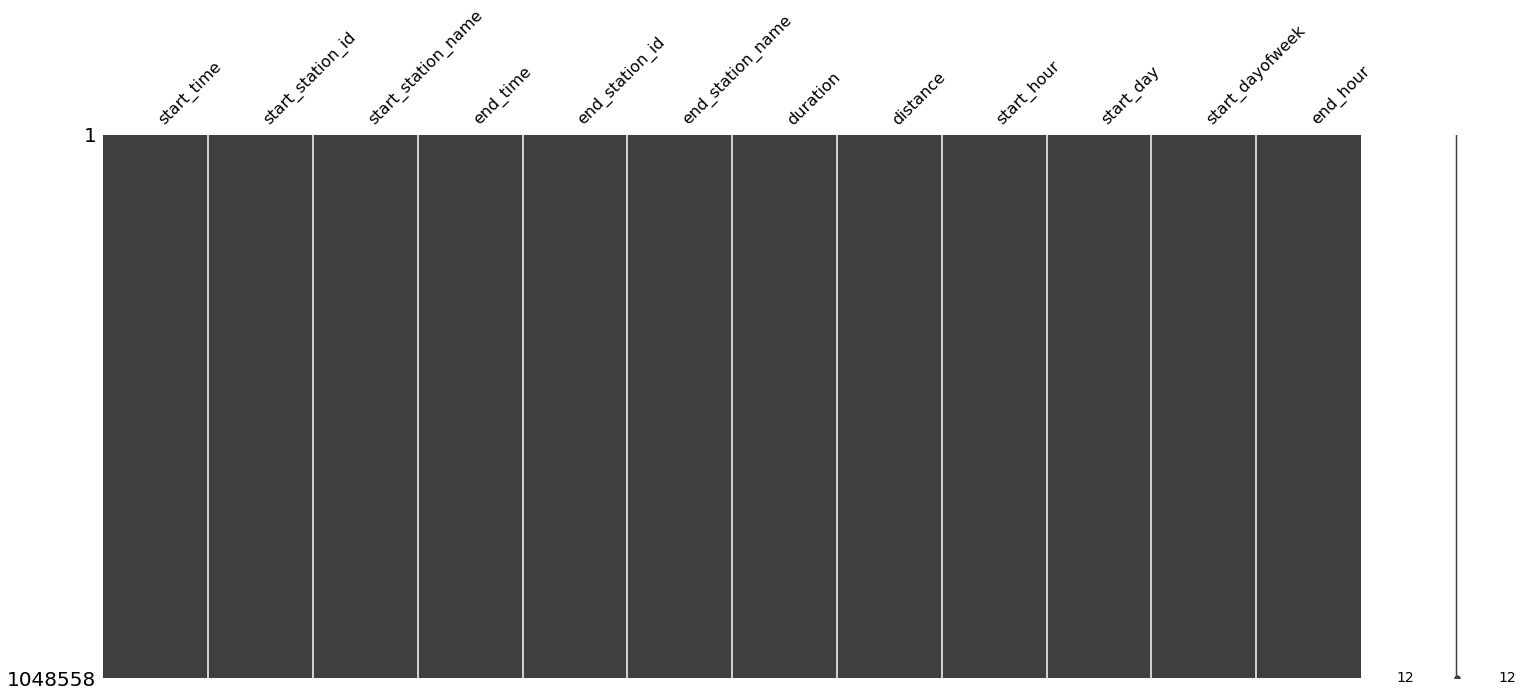

In [11]:
import missingno as msno
msno.matrix(trips)

In [12]:
s_eng = pd.read_csv('C:\\Users\\82104\\Desktop\\New_Seoul_Bike\\Data\\Station\\Seoul_Distict_ID_English.csv', encoding = 'euc-kr')
s_eng = s_eng.drop(columns=['county_id','lat','long'])
s_kr = pd.read_csv('C:\\Users\\82104\\Desktop\\New_Seoul_Bike\\Data\\Station\\station_df_facilities_info.csv', encoding = 'cp949')
station = pd.merge(s_eng, s_kr, how = "inner", on = "county")
station.head()

county county_eng  station_id station_name        lat        long  \
0    도봉구     Dobong        1702   녹천역 1번출구 앞  37.646172  127.050560   
1    도봉구     Dobong        1703   도봉산광역환승센터앞  37.689720  127.045197   
2    도봉구     Dobong        1705     도봉구청 정문앞  37.669224  127.046516   
3    도봉구     Dobong        1706       기업은행 앞  37.665665  127.042671   
4    도봉구     Dobong        1707       도봉구민회관  37.654461  127.038513   

  station_install_date  capa rent_type  dong  bus_min_dist  \
0             5/8/2017    10       LCD   번1동     65.854878   
1            5/11/2017    15       LCD   창1동     62.015531   
2             5/8/2017     8       LCD  도봉1동     30.788507   
3            6/27/2017    10       LCD  방학1동     33.531927   
4             5/8/2017    15       LCD  방학1동     31.866318   

   num_bus_within_150m  subway_500m  culture_500m  school_500m  market_500m  \
0                    1            1             0            5            0   
1                    6            2             0            1            0   
2                    5            1             1            2            0   
3                    4            1             1            1            0   
4                    5            0             6            5            0   

   tour_500m  
0          0  
1          1  
2          1  
3          3  
4          2

In [13]:
station.shape

(2154, 17)

In [14]:
station = station.astype({
    "county": "category",
    "county_eng": "category",
    "station_id": "category",
    "lat": "category",
    "long": "category"
})

Let's join Rent station first

In [23]:
trips.shape

(1048558, 12)

In [34]:
station.head()

county county_eng station_id station_name        lat        long  \
0    도봉구     Dobong       1702   녹천역 1번출구 앞  37.646172  127.050560   
1    도봉구     Dobong       1703   도봉산광역환승센터앞  37.689720  127.045197   
2    도봉구     Dobong       1705     도봉구청 정문앞  37.669224  127.046516   
3    도봉구     Dobong       1706       기업은행 앞  37.665665  127.042671   
4    도봉구     Dobong       1707       도봉구민회관  37.654461  127.038513   

  station_install_date  capa rent_type  dong  bus_min_dist  \
0             5/8/2017    10       LCD   번1동     65.854878   
1            5/11/2017    15       LCD   창1동     62.015531   
2             5/8/2017     8       LCD  도봉1동     30.788507   
3            6/27/2017    10       LCD  방학1동     33.531927   
4             5/8/2017    15       LCD  방학1동     31.866318   

   num_bus_within_150m  subway_500m  culture_500m  school_500m  market_500m  \
0                    1            1             0            5            0   
1                    6            2             0            1            0   
2                    5            1             1            2            0   
3                    4            1             1            1            0   
4                    5            0             6            5            0   

   tour_500m  
0          0  
1          1  
2          1  
3          3  
4          2

In [48]:
before_merged = len(trips)
df = pd.merge(trips, station[['county','county_eng','station_id','lat','long']],
              left_on="start_station_id",
              right_on="station_id").drop(columns='station_id')
df.head()

start_time start_station_id start_station_name            end_time  \
0 2021-02-01 00:00:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 00:03:00   
1 2021-02-01 00:01:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 00:11:00   
2 2021-02-01 00:51:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 00:53:00   
3 2021-02-01 09:34:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 09:36:00   
4 2021-02-01 09:39:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 10:00:00   

  end_station_id  end_station_name  duration  distance  start_hour  start_day  \
0           1554             번동사거리       2.0    736.02           0          1   
1           1536    번동 두산위브 101동 옆       9.0    597.75           0          1   
2           1552  강북구청사거리(던킨도너츠 앞)       1.0    140.00           0          1   
3           1569           수유역2번출구       2.0      0.00           9          1   
4           1514  강북구청 사거리 버스정류소 앞      21.0   2505.19           9          1   

   start_dayofweek  end_hour county county_eng        lat        long  
0                0         0    강북구    Gangbuk  37.638805  127.028358  
1                0         0    강북구    Gangbuk  37.638805  127.028358  
2                0         0    강북구    Gangbuk  37.638805  127.028358  
3                0         9    강북구    Gangbuk  37.638805  127.028358  
4                0        10    강북구    Gangbuk  37.638805  127.028358

In [49]:
df.shape

(1035715, 16)

Now let's join Return station

In [50]:
df = pd.merge(df, station[['county','county_eng','station_id','lat','long']], 
              left_on="end_station_id", 
              right_on="station_id").drop(columns='station_id')
df.head()

start_time start_station_id start_station_name            end_time  \
0 2021-02-01 00:00:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 00:03:00   
1 2021-02-01 18:01:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 18:08:00   
2 2021-02-01 20:21:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 20:27:00   
3 2021-02-01 20:32:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 20:38:00   
4 2021-02-03 00:12:00             1514   강북구청 사거리 버스정류소 앞 2021-02-03 00:14:00   

  end_station_id end_station_name  duration  distance  start_hour  start_day  \
0           1554            번동사거리       2.0    736.02           0          1   
1           1554            번동사거리       7.0    779.26          18          1   
2           1554            번동사거리       5.0      0.00          20          1   
3           1554            번동사거리       5.0    736.02          20          1   
4           1554            번동사거리       2.0    628.99           0          3   

   start_dayofweek  end_hour county_x county_eng_x      lat_x      long_x  \
0                0         0      강북구      Gangbuk  37.638805  127.028358   
1                0        18      강북구      Gangbuk  37.638805  127.028358   
2                0        20      강북구      Gangbuk  37.638805  127.028358   
3                0        20      강북구      Gangbuk  37.638805  127.028358   
4                2         0      강북구      Gangbuk  37.638805  127.028358   

  county_y county_eng_y      lat_y      long_y  
0      강북구      Gangbuk  37.635391  127.034554  
1      강북구      Gangbuk  37.635391  127.034554  
2      강북구      Gangbuk  37.635391  127.034554  
3      강북구      Gangbuk  37.635391  127.034554  
4      강북구      Gangbuk  37.635391  127.034554

In [150]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 578407 entries, 0 to 578406
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   start_time          578407 non-null  datetime64[ns]
 1   start_station_id    578407 non-null  object        
 2   start_station_name  578407 non-null  object        
 3   end_time            578407 non-null  datetime64[ns]
 4   end_station_id      578407 non-null  object        
 5   end_station_name    578407 non-null  object        
 6   duration            578407 non-null  float64       
 7   distance            578407 non-null  float64       
 8   start_hour          578407 non-null  int64         
 9   start_day           578407 non-null  int64         
 10  start_dayofweek     578407 non-null  int64         
 11  end_hour            578407 non-null  int64         
 12  county_x            578407 non-null  category      
 13  county_eng_x        578407 no

In [51]:
df.shape

(578407, 20)

In [52]:
# after_merged = len(df)
# loss = before_merged - after_merged

# print(df.shape)
# print("%d loss. (%d%%)" %(loss, float(loss)/before_merged*100))

(578407, 20)
470151 loss. (44%)


# Which Day of Week and Hour had the most frequent trips? 

Let's start with the simplest question.
We will look at trips taken by **Day of Week, Hour, County** respectively

## Trips by Day of Week

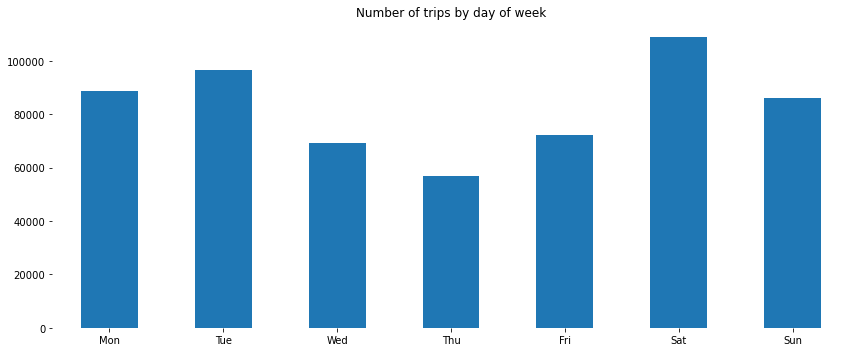

In [55]:
use_by_dayofweek = df.groupby('start_dayofweek').size()
use_by_dayofweek.index = "Mon Tue Wed Thu Fri Sat Sun".split()
use_by_dayofweek.plot(kind='bar', figsize=(12, 5), rot=0, title="Number of trips by day of week")
plt.box(False)
plt.tight_layout()
plt.show()

There are  27.1% more trips taken during weekends than weekdays.
During weekdays, people rode more often on Tuesday and Wednesday.
During weekends, people came out to ride bikes more on Saturday than Sunday.


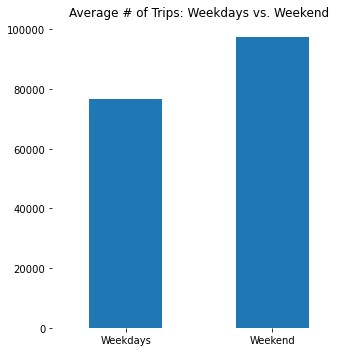

In [56]:
mean_weekday = use_by_dayofweek.loc["Mon Tue Wed Thu Fri".split()].mean()
mean_weekend = use_by_dayofweek.loc["Sat Sun".split()].mean()

pd.Series(data=[
    mean_weekday,
    mean_weekend
], index=["Weekdays", "Weekend"]).plot(kind='bar', figsize=(5, 5), rot=0, title="Average # of Trips: Weekdays vs. Weekend")
plt.box(False)
plt.tight_layout()
plt.show()

In [57]:
diff = (mean_weekend - mean_weekday) / mean_weekday * 100
print("There are %.1f%% more trips during weekends than weekdays." %diff)

There are 27.1% more trips during weekends than weekdays.


There are 27.1% more trips during weekends than weekdays.

## Trips by Hour

We can presume that the trip pattern might look different between weekdays and weekends. Let's compare them and see if the difference exists.

### On Weekdays

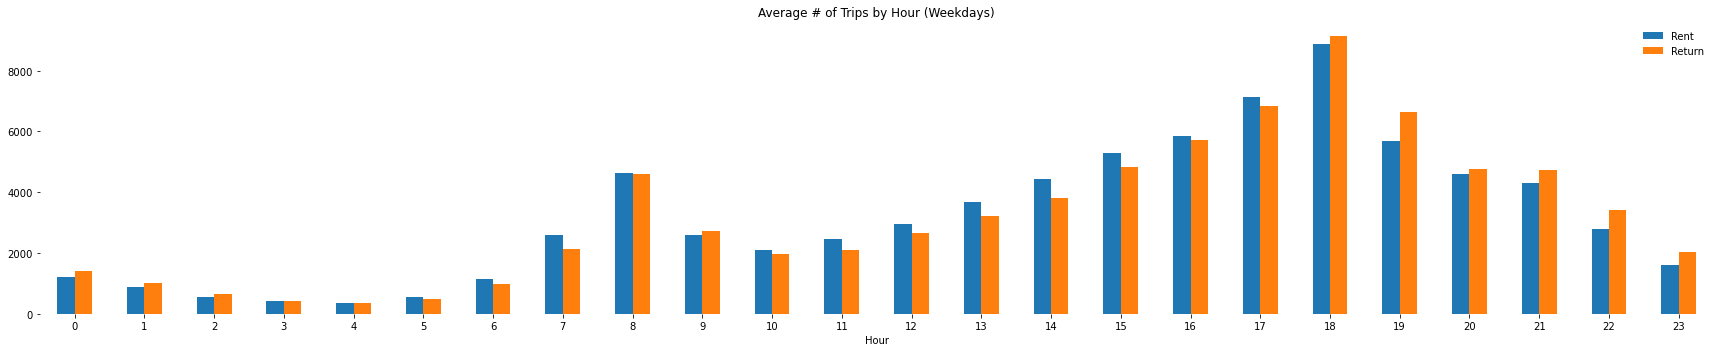

In [58]:
pd.DataFrame(data={
    "Rent": df[df['start_dayofweek'].isin(set(range(0, 5)))].groupby('start_hour').size()//5,
    "Return": df[df['start_dayofweek'].isin(set(range(0, 5)))].groupby('end_hour').size()//5
}).plot(kind='bar', figsize=(24, 5), rot=0, title="Average # of Trips by Hour (Weekdays)")
plt.xlabel("Hour")
plt.box(False)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### On Weekends

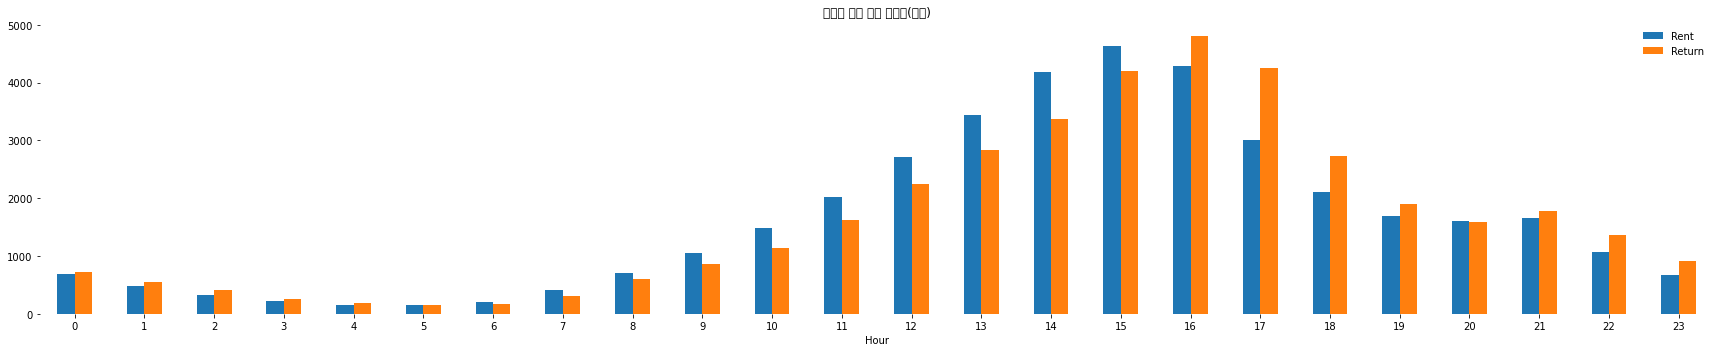

In [61]:
pd.DataFrame(data={
    "Rent": df[df['start_dayofweek'].isin(set(range(5, 7)))].groupby('start_hour').size()//5,
    "Return": df[df['start_dayofweek'].isin(set(range(5, 7)))].groupby('end_hour').size()//5
}).plot(kind='bar', figsize=(24, 5), rot=0, title="시간에 따른 평균 이용량(주말)")
plt.xlabel("Hour")
plt.box(False)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

We can observe the following:
- **On Weekdays, relatively more trips are taken at 8 am and 18 pm.** This may be due to commute time. Yes, people work 9 to 6 in Korea (one more hour than 9-5 in the US).
- **On Weekends, more trips are taken as it gets late in the afternoon**  and hits the peak around 18pm. This may vary depending on the season and the sunset time.
- Otherwise, except for commute time. **Rent > Return in the afternoon and the other way around at night.**

## 1.3. Does Hourly Trip Pattern Look Different by County?

### Rent

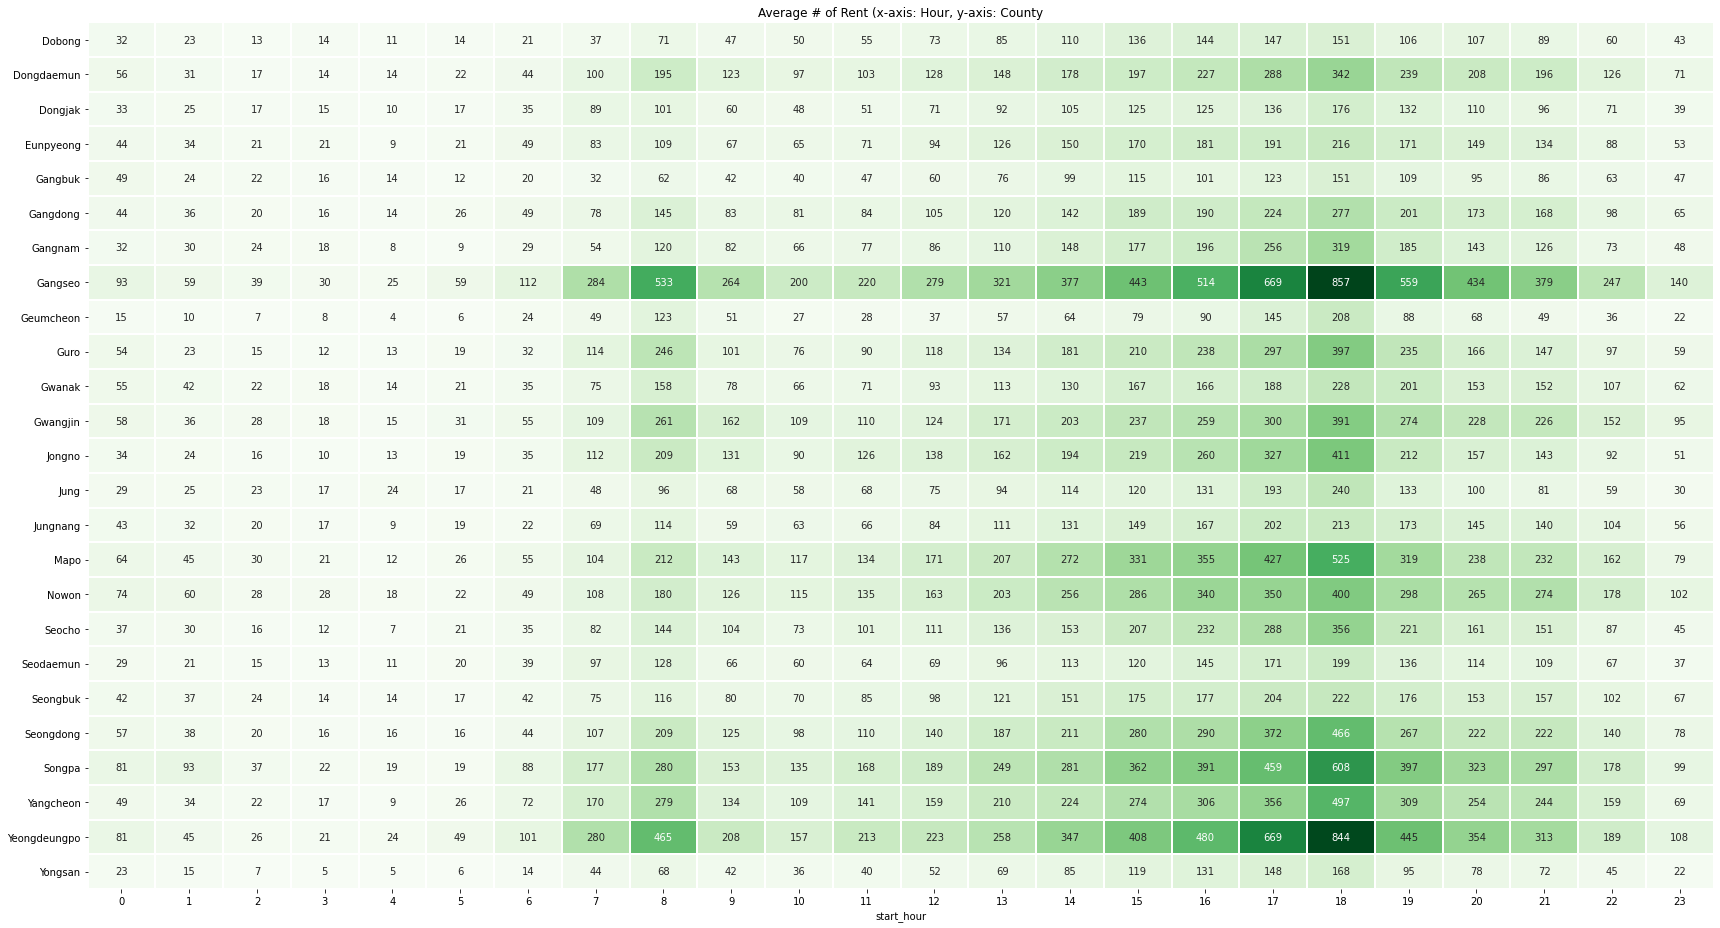

In [62]:
pvt_table = (df[df['start_dayofweek'].isin(set(range(0, 5)))].groupby(['county_eng_x', 'start_hour']).size()//5).unstack()

plt.figure(figsize=(24, 13))
sns.heatmap(pvt_table, annot=True, fmt='d', cmap="Greens", cbar=False, linewidth=1)
plt.title("Average # of Rent (x-axis: Hour, y-axis: County")
plt.ylabel("")
plt.tight_layout()
plt.show()

### Return

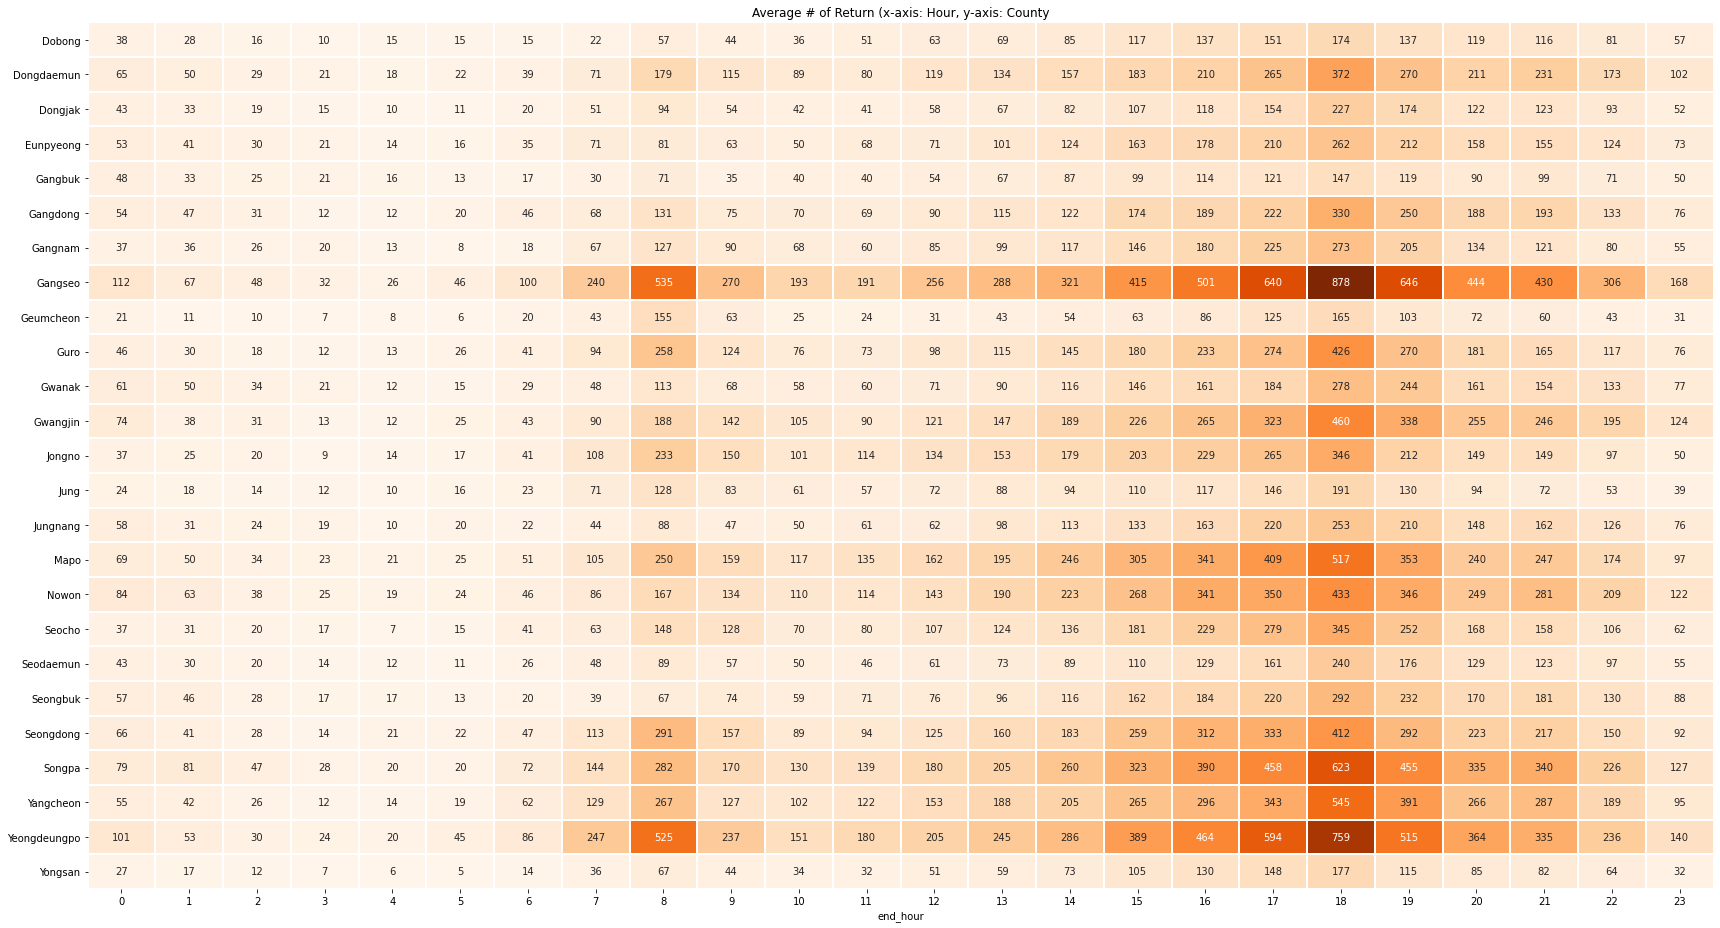

In [63]:
pvt_table = (df[df['start_dayofweek'].isin(set(range(0, 5)))].groupby(['county_eng_y', 'end_hour']).size()//5).unstack()

plt.figure(figsize=(24, 13))
sns.heatmap(pvt_table, annot=True, fmt='d', cmap="Oranges", cbar=False, linewidth=1)
plt.title("Average # of Return (x-axis: Hour, y-axis: County")
plt.ylabel("")
plt.tight_layout()
plt.show()

**All counties have a very simliar hourly trip patterns.**

The dark colors in commute time sticks out which makes me wonder:
- In which county is the # of Rent > # of Return?
- In which county is the # of Rent < # of Return?

which sums up to the following question:

- **Are the counties that have higher Rent or Return during commute time?**

### 1.4. Are the counties that have higher Rent or Return during commute time?

Let's extract the trips taken during communte time (8am and 18pm). In addition, let's look at the Rent to Return Raio.

In [64]:
pvt_table = (df[df['start_dayofweek'].isin(set(range(0, 5)))].groupby(['county_eng_x', 'start_hour']).size()//5)
rent = pd.DataFrame([pvt_table.xs(8,level=1), pvt_table.xs(18,level=1)], index=[8, 18])

pvt_table = (df[df['start_dayofweek'].isin(set(range(0, 5)))].groupby(['county_eng_y', 'end_hour']).size()//5)
ret = pd.DataFrame([pvt_table.xs(8,level=1), pvt_table.xs(18,level=1)], index=[8, 18])

In [65]:
total = rent+ret
rent = rent / total
ret = ret / total

In [69]:
morning_diff = pd.DataFrame([rent.T[8], ret.T[8]], index=['Rent', 'REturn']).T.sort_values('Rent')
eve_diff = pd.DataFrame([rent.T[18], ret.T[18]], index=['Rent', 'Return']).T.sort_values('Rent')

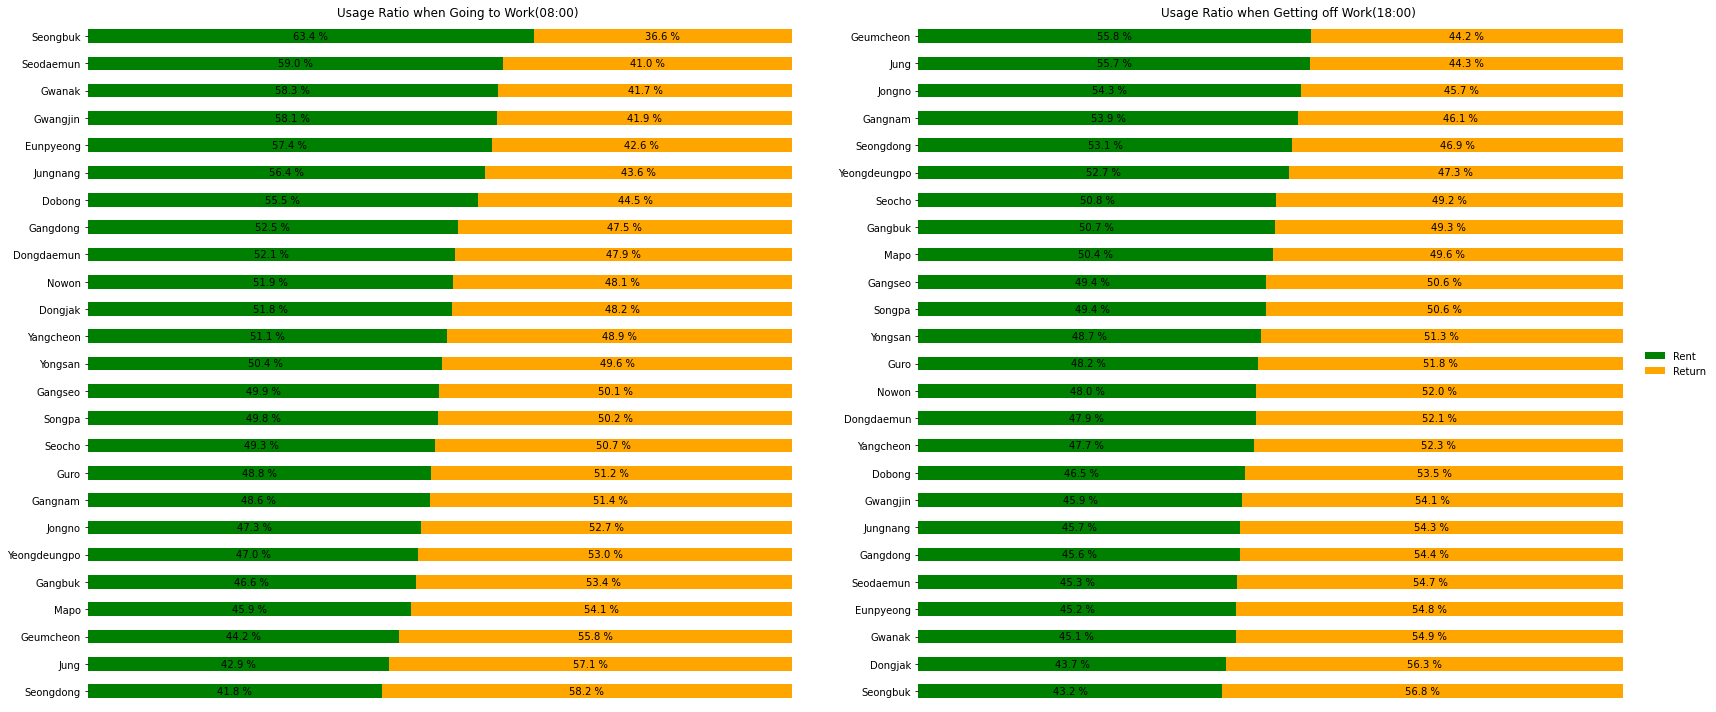

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for i, (diff, time_name) in enumerate(zip([morning_diff, eve_diff], ["Going to Work(08:00)", "Getting off Work(18:00)"])):
    ax = diff.plot(kind='barh', color=['green', 'orange'], stacked=True, title="Usage Ratio when %s"%time_name, ax=axes[i])

    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1f %%"%(width*100), xy=(left+width/2, bottom+height/2), ha='center', va='center')

    plt.sca(ax)
    plt.xticks([])
    plt.box(False)
axes[0].get_legend().remove()
plt.legend(loc='center left', bbox_to_anchor=(0.97, 0.5), frameon=False)
plt.tight_layout()
plt.show()

- In the morning commute time, **Seongbuk had 26% more Rents than Returns.**
- In the evening commute time, **Geumcheon had 10% more Returns than Rents.**
- In the evening commute time, **Seongbuk had 15% more Returns than Rents.**

However, the two plots above have different order of y-axis, so it's quiet difficult to compare the difference in morning and evening commute time.

Let's visualize just the Rents this time because Returns = Trips - Rents. 

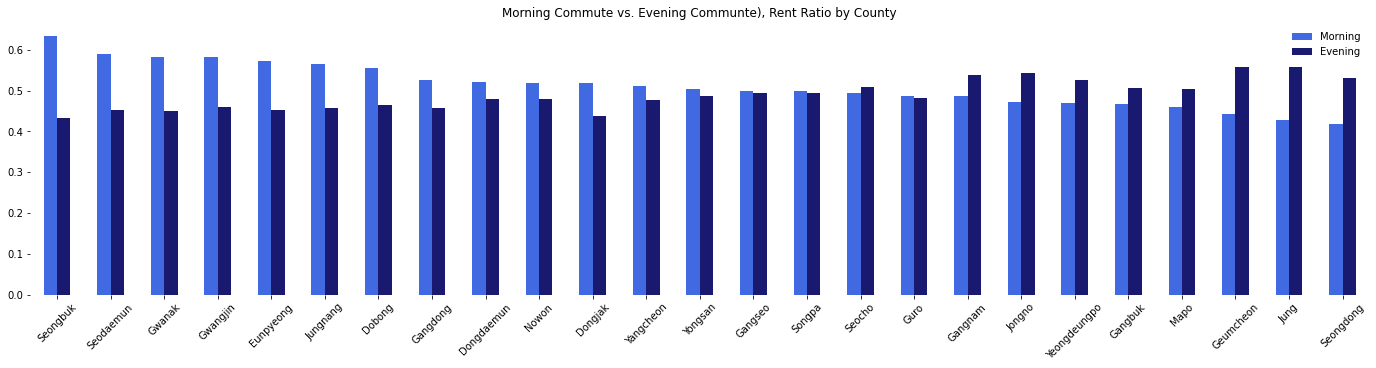

In [76]:
morning_eve_diff = pd.DataFrame([morning_diff['Rent'], eve_diff['Rent']], index=['Morning', 'Evening']).T
morning_eve_diff.sort_values('Morning', inplace=True, ascending=False)

morning_eve_diff.plot(kind='bar', figsize=(24, 5), title="Morning Commute vs. Evening Communte), Rent Ratio by County", rot=0, color=['royalblue', 'midnightblue'])
plt.box(False)
plt.xticks(rotation = 45)
plt.legend(frameon=False)
plt.show()

The morning commute bars graudlly decrease, while the evening commute bars gradually increase.

In other words, **counties with higher Rent rate in the morning have higher Return rate in the evening (The correlation is 0.8).**

We can imagine that **people ride Seoul bikes from home -> work -> home on weekdays**

Well, this may be pretty obvious, but we can verify our groundless inference with this visualization now!

## 2. Which County has High Trip Distance and Trip Hour?

We can assume that a county with high average trip distance and trip hour has more riders who travel a far distance or ride longer.

Let's first look at the trip distance

## Trip Distance

Let's draw the distribution in boxplot and distplot.

In [77]:
distance = df['distance']

# Exclude 0
distance = distance[distance != 0]

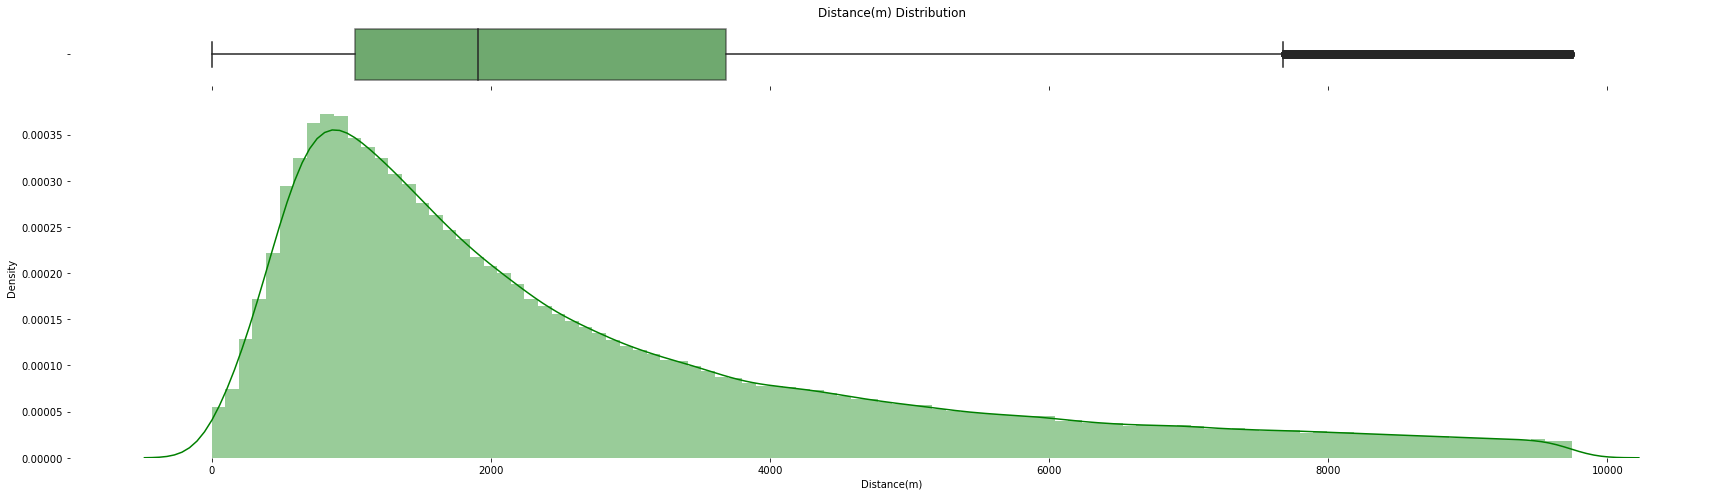

In [82]:
def draw_box_distplot(series, title, xlabel, axvline=False, color='C0', bins=100):
    # Cut the window in 2 parts
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(24, 7))

    # Add a graph in each part
    sns.boxplot(series, ax=ax_box, boxprops={'alpha':0.6}, color=color)
    sns.distplot(series, ax=ax_hist, color=color, bins=bins)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')

    plt.sca(ax_box)
    plt.box(False)
    plt.title(title)
    plt.sca(ax_hist)
    plt.box(False)
    plt.xlabel(xlabel)
    
    if axvline:
        plt.axvline(series.mean(), color='green')
        plt.axvline(series.value_counts().idxmax(), color='red')
        plt.axvline(series.median(), color='blue')
    
    plt.tight_layout()
    plt.show()
    
draw_box_distplot(distance, "Distance(m) Distribution", "Distance(m)", color='green')

The distribution is skewed due to outliers.
Let's remove the outliers for the sake of better analysis.

In [79]:
def remove_outlier(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    series_out = series.loc[(series > fence_low) & (series < fence_high)]
    return series_out

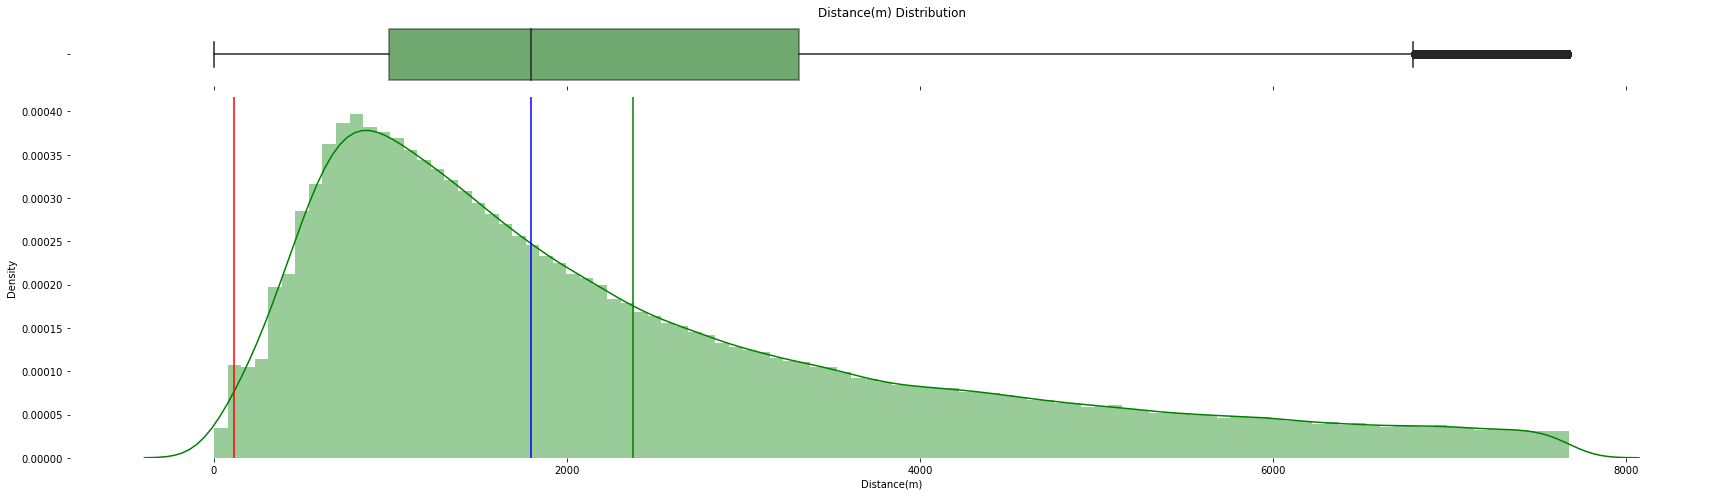

In [83]:
distance = remove_outlier(distance)

draw_box_distplot(distance, "Distance(m) Distribution", "Distance(m)", axvline=True, color='green')

In [89]:
#print("Mode: %dm" %distance.value_counts().idxmax())
print("Median: %dm" %distance.median())
print("Truncated Mean(5~95%%): %dm" %distance.mean())

Median: 1798m
Truncated Mean(5~95%): 2370m


The distribution is still skewed a little bit, but the median is 1798 meters.

Let's dig a little deeper by looking at distributions by county.

In [90]:
distance = df['distance']

# Exclude 0 
distance = distance[distance != 0]

In [91]:
distance_df_total = None
dist_by_region = df.groupby('county_eng_x')

for name, g_df in dist_by_region:
    distance = remove_outlier(g_df['distance']).reset_index(drop=True)
    distance_df = pd.DataFrame(distance)
    distance_df['county_eng'] = name
    
    if distance_df_total is None:
        distance_df_total = distance_df
    else:
        distance_df_total = distance_df_total.append(distance_df, ignore_index=True)

distance_df_total.head()

distance county_eng
0   1984.84     Dobong
1   2950.00     Dobong
2    976.96     Dobong
3    317.95     Dobong
4    976.99     Dobong

In [92]:
medians = distance_df_total.groupby('county_eng')['distance'].median()
medians = medians.sort_values(ascending=False)
medians

county_eng
Yongsan         2633.600
Gangnam         2617.935
Seongdong       2370.000
Seocho          2120.470
Mapo            2091.800
Seodaemun       1997.865
Dongjak         1985.550
Guro            1956.540
Dobong          1931.530
Songpa          1902.760
Seongbuk        1889.220
Gwanak          1880.710
Geumcheon       1870.000
Nowon           1806.325
Gangbuk         1782.775
Yeongdeungpo    1759.990
Dongdaemun      1642.770
Gwangjin        1629.950
Jung            1624.960
Eunpyeong       1604.430
Gangdong        1570.580
Jungnang        1568.530
Yangcheon       1517.460
Jongno          1421.980
Gangseo         1345.650
Name: distance, dtype: float64

In [93]:
distance_medians = medians

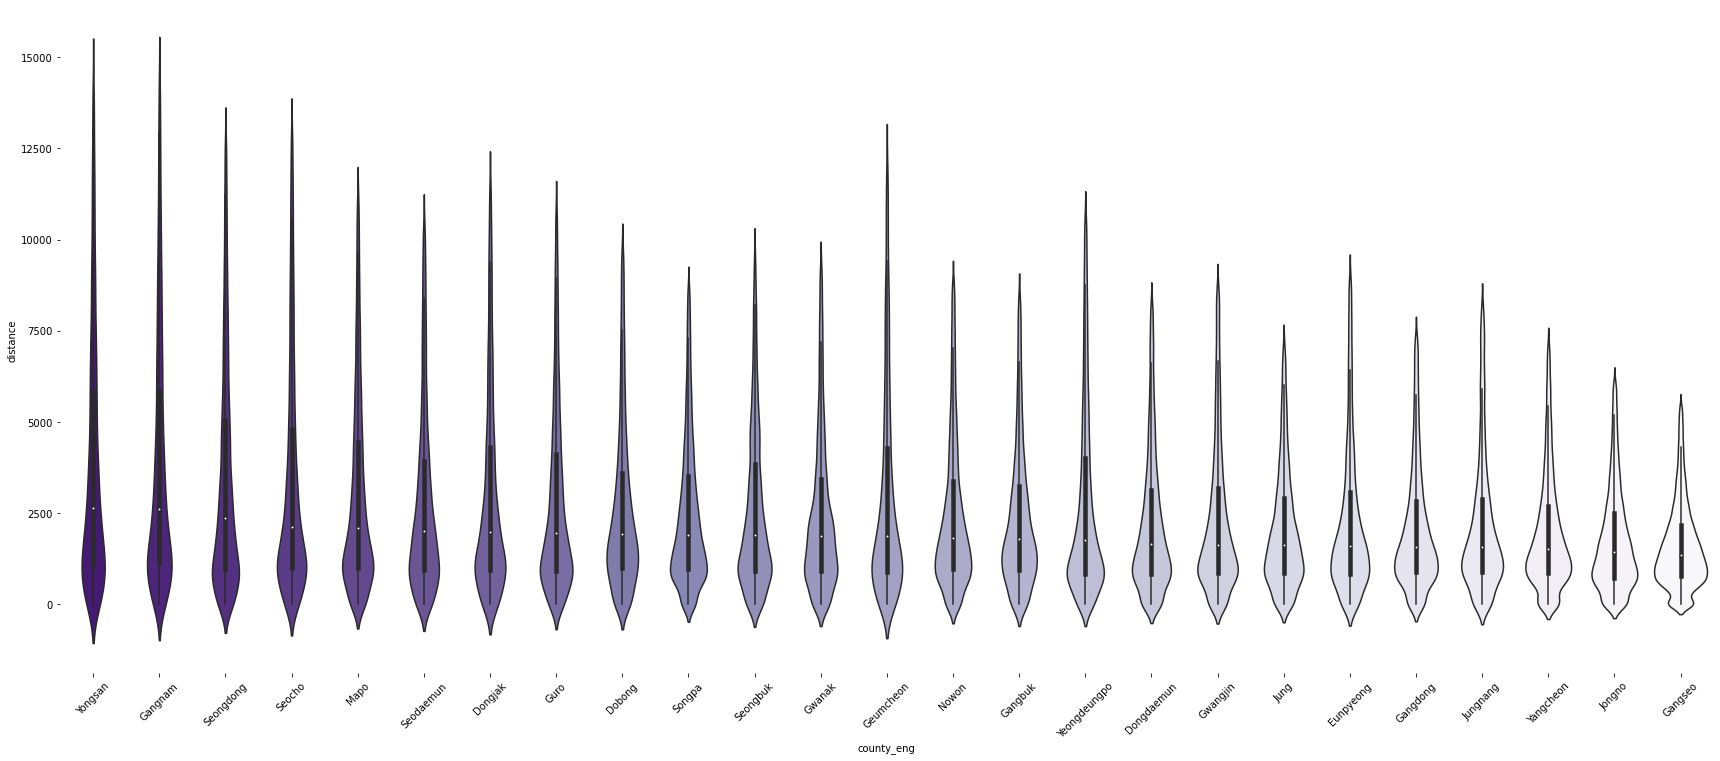

In [96]:
plt.figure(figsize=(24, 10))
sns.violinplot(x='county_eng', y='distance', data=distance_df_total, order=medians.index, palette="Purples_r")
plt.tight_layout()
plt.xticks(rotation = 45)
plt.box(False)
plt.show()

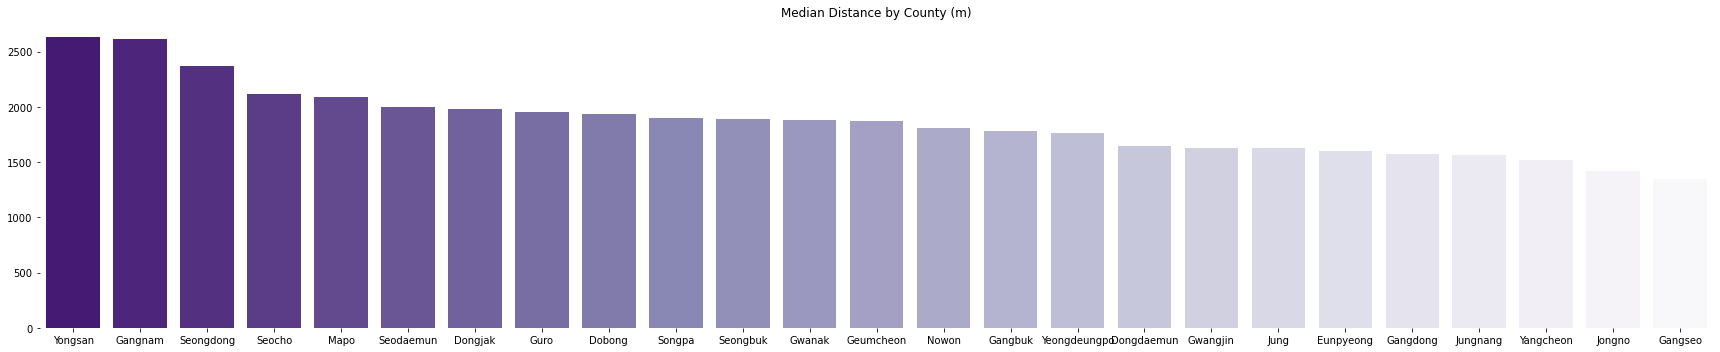

In [97]:
plt.figure(figsize=(24, 5))
sns.barplot(x='county_eng', y='distance', data=medians.reset_index(), palette="Purples_r")
plt.xlabel("")
plt.ylabel("")
plt.title("Median Distance by County (m)")
plt.box(False)
plt.tight_layout()
plt.show()

- The distributions are skewed in every county.
- Counties with longer distance tend to have higher median as well as more outliers.

## 2.2 Trip Hour

### Distribution of All Trips

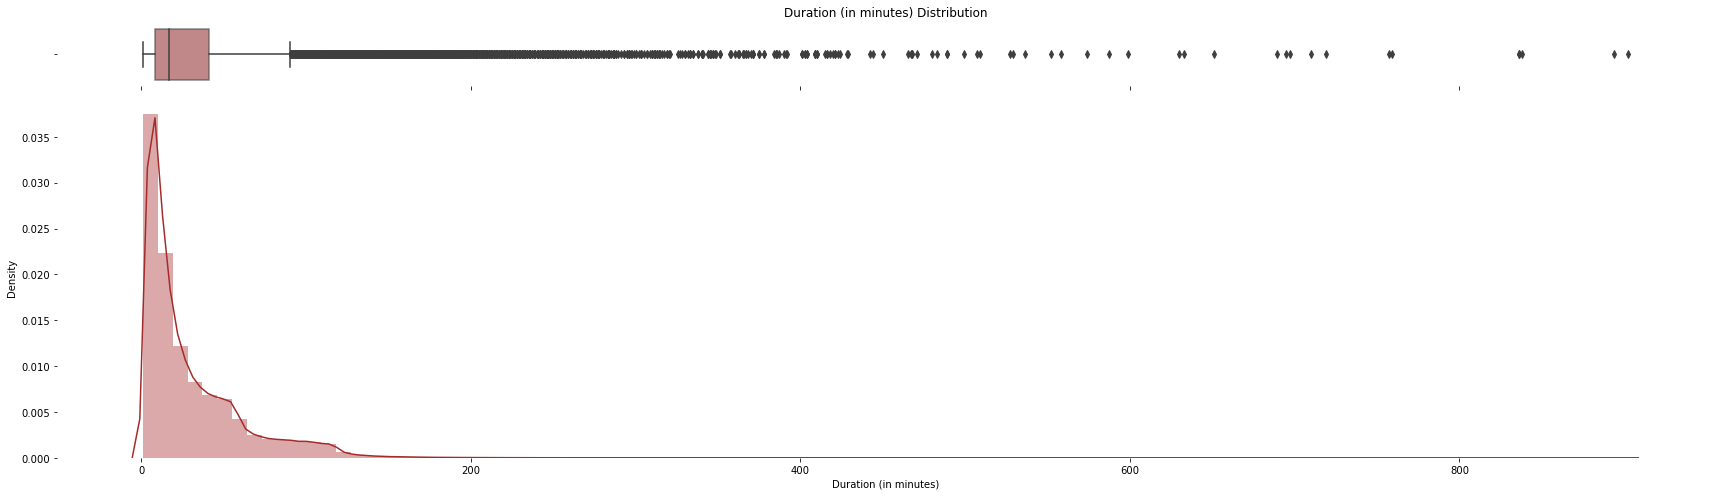

In [98]:
time = df['duration']
time = time[time != 0]

draw_box_distplot(time, "Duration (in minutes) Distribution", "Duration (in minutes)", color='brown')

### Distribution without Outliers

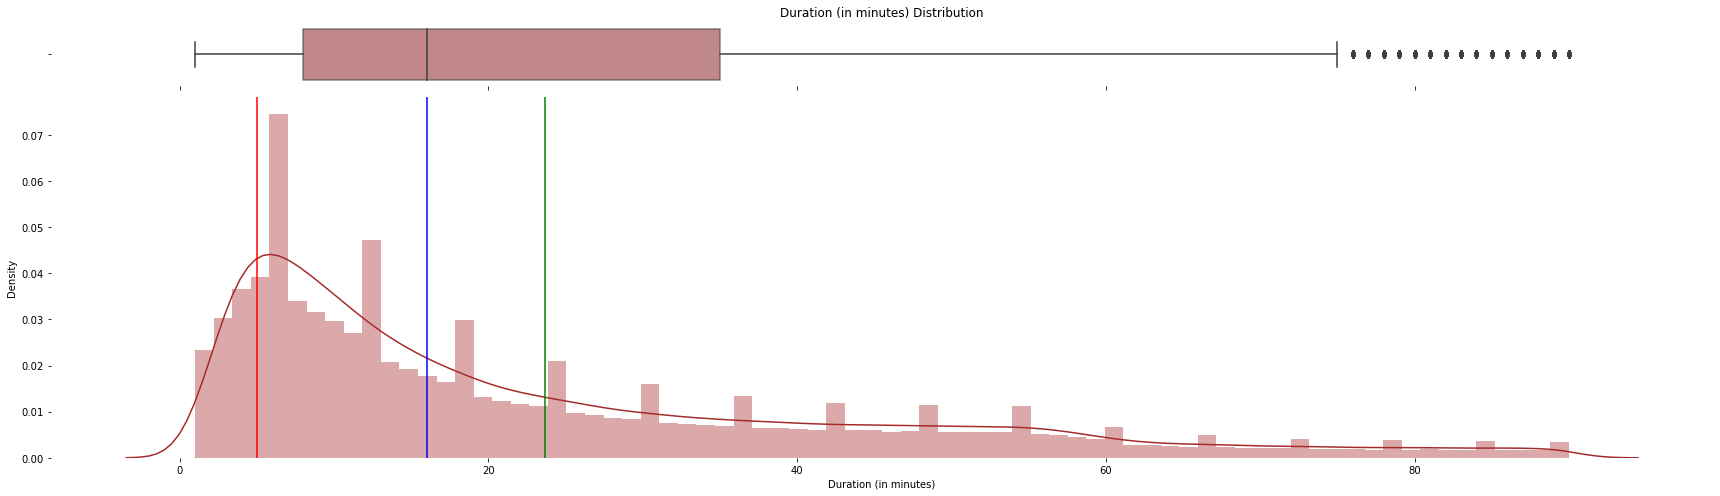

In [99]:
time = remove_outlier(time)

draw_box_distplot(time, "Duration (in minutes) Distribution", "Duration (in minutes)", axvline=True, color='brown', bins=74)

In [100]:
print("Mode: %d Minutes" %time.value_counts().idxmax())
print("Median: %d Minutes" %time.median())
print("Truncated Mean(5~95%%): %d Minutes" %time.mean())

Mode: 5 Minutes
Median: 16 Minutes
Truncated Mean(5~95%): 23 Minutes


Distributions for distance and hour look very simliar.
Mode is 5 minutes, and median is 16 minutes.

In [101]:
usetime_df_total = None
usetime_by_region = df.groupby('county_eng_x')

for name, g_df in usetime_by_region:
    usetime = remove_outlier(g_df['duration']).reset_index(drop=True)
    usetime_df = pd.DataFrame(usetime)
    usetime_df['county_eng'] = name
    
    if usetime_df_total is None:
        usetime_df_total = usetime_df
    else:
        usetime_df_total = usetime_df_total.append(usetime_df, ignore_index=True)

usetime_df_total.head()

duration county_eng
0      17.0     Dobong
1      31.0     Dobong
2       5.0     Dobong
3       7.0     Dobong
4      12.0     Dobong

In [102]:
medians = usetime_df_total.groupby('county_eng')['duration'].median()
medians = medians.sort_values(ascending=False)
medians

county_eng
Yongsan         25.0
Gangnam         25.0
Seongdong       23.0
Mapo            21.0
Seocho          20.0
Dongjak         18.0
Guro            17.0
Yeongdeungpo    17.0
Seodaemun       17.0
Dobong          17.0
Geumcheon       17.0
Gangbuk         17.0
Nowon           16.0
Seongbuk        16.0
Songpa          16.0
Gwanak          15.0
Gwangjin        15.0
Jung            15.0
Dongdaemun      14.0
Jungnang        14.0
Gangdong        14.0
Eunpyeong       14.0
Yangcheon       13.0
Jongno          13.0
Gangseo         10.0
Name: duration, dtype: float64

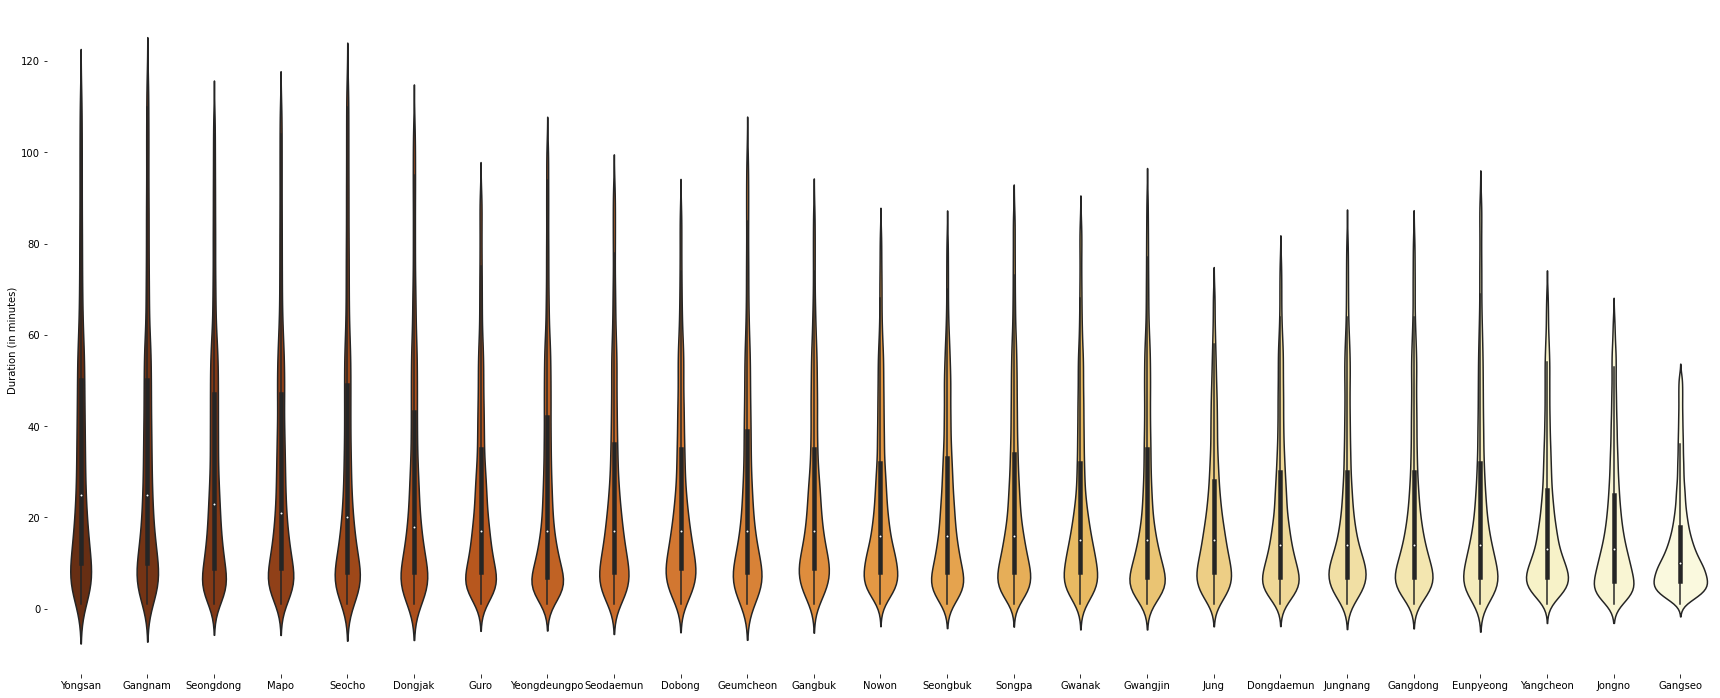

In [103]:
plt.figure(figsize=(24, 10))
sns.violinplot(x='county_eng', y='duration', data=usetime_df_total, order=medians.index, palette='YlOrBr_r')
plt.tight_layout()
plt.box(False)
plt.xlabel("")
plt.ylabel("Duration (in minutes)")
plt.show()

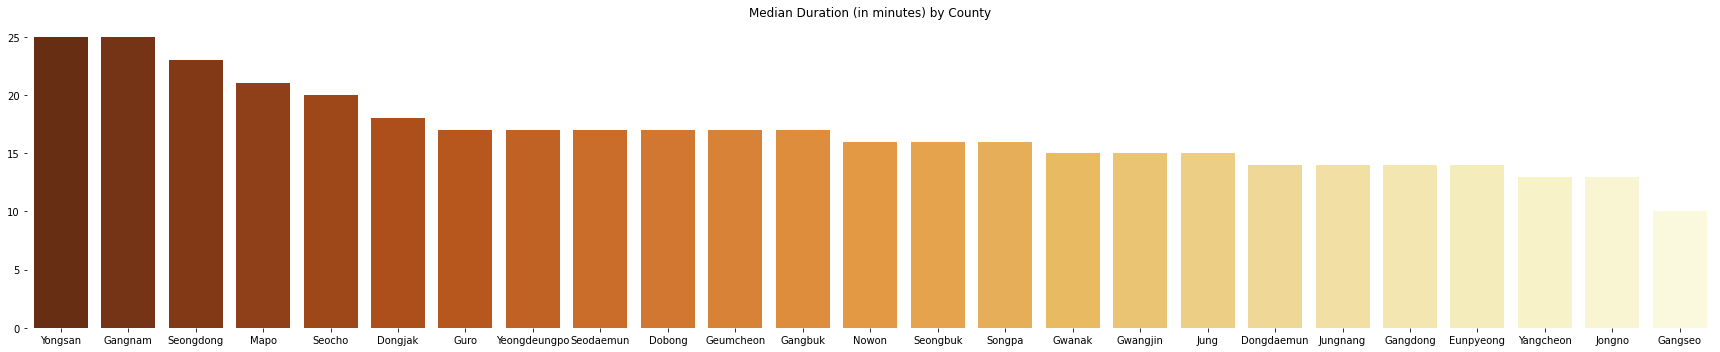

In [104]:
plt.figure(figsize=(24, 5))
sns.barplot(x='county_eng', y='duration', data=medians.reset_index(), palette='YlOrBr_r')
plt.xlabel("")
plt.ylabel("")
plt.title("Median Duration (in minutes) by County")
plt.box(False)
plt.tight_layout()
plt.show()

Trip hour is very simliar to Trip distance.

It's interesting that some counties (Yongsan, Gangnam) have more outlier than others (Gangseo). 

Putting both distance and trip hour into maps:

In [105]:
usetime_medians = medians

In [106]:
usetime_df_total

duration county_eng
0           17.0     Dobong
1           31.0     Dobong
2            5.0     Dobong
3            7.0     Dobong
4           12.0     Dobong
...          ...        ...
543068      98.0    Yongsan
543069      38.0    Yongsan
543070      38.0    Yongsan
543071      33.0    Yongsan
543072      33.0    Yongsan

[543073 rows x 2 columns]

In [107]:
usetime_df_total = None
usetime_by_region = df.groupby('county_x')

for name, g_df in usetime_by_region:
    usetime = remove_outlier(g_df['duration']).reset_index(drop=True)
    usetime_df = pd.DataFrame(usetime)
    usetime_df['county'] = name
    
    if usetime_df_total is None:
        usetime_df_total = usetime_df
    else:
        usetime_df_total = usetime_df_total.append(usetime_df, ignore_index=True)

usetime_df_total.head()

duration county
0      88.0    강남구
1      68.0    강남구
2     109.0    강남구
3      57.0    강남구
4      76.0    강남구

In [108]:
distance_df_total = None
dist_by_region = df.groupby('county_x')

for name, g_df in dist_by_region:
    distance = remove_outlier(g_df['distance']).reset_index(drop=True)
    distance_df = pd.DataFrame(distance)
    distance_df['county'] = name
    
    if distance_df_total is None:
        distance_df_total = distance_df
    else:
        distance_df_total = distance_df_total.append(distance_df, ignore_index=True)

distance_df_total.head()

distance county
0  12586.15    강남구
1  11725.22    강남구
2  11650.81    강남구
3   9965.30    강남구
4   5535.63    강남구

In [109]:
usetime_medians = usetime_df_total.groupby('county')['duration'].median().sort_values(ascending=False)
distance_medians = distance_df_total.groupby('county')['distance'].median().sort_values(ascending=False)

In [110]:
bike_map = folium.plugins.DualMap(location=[37.541, 126.986], zoom_start=10, tiles='cartodbpositron', zoom_control=False)
folium.Choropleth(geo_data=geo_str,
                  data=distance_medians,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Purples',
                  line_color='grey', line_opacity=0.5).add_to(bike_map.m1)
folium.Choropleth(geo_data=geo_str,
                  data=usetime_medians,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='YlOrBr',
                  line_color='grey', line_opacity=0.5).add_to(bike_map.m2)
bike_map

- **Yongsan has the highest distance and trip hours.**
- Distance and trip hour has a very strong correlation (0.95). This is not a surprise since a rider has to take a longer trip to go further.

## Which County Has High Outflow/Inflow of riders?

Outflow/Inflow represent trips of riders that traveled across from A to B county.
We can get the traffic traveling across counties this way.

Since the scale of the nunmber of trips differs by counties, we will look at a relative ratio between counties instead of absolute value.

- Outflow Ratio: Return at a different county after Renting at County A / Total number of Rents at County A
- Inflow Ratio: Return at County A after Renting at a different county / Total number of Returns at County A

In short, we want to know **how much % of Rents(Returns) at County A are Returned(Rented) at another county.**

### Mapping Outflow/Inflow Ratio of Counties

We can first check which counties have high outflow ratio or inflow ratio.

In [111]:
df.columns

Index(['start_time', 'start_station_id', 'start_station_name', 'end_time',
       'end_station_id', 'end_station_name', 'duration', 'distance',
       'start_hour', 'start_day', 'start_dayofweek', 'end_hour', 'county_x',
       'county_eng_x', 'lat_x', 'long_x', 'county_y', 'county_eng_y', 'lat_y',
       'long_y'],
      dtype='object')

In [112]:
df['county_x'].unique()

['강북구', '도봉구', '성북구', '노원구', '동대문구', ..., '양천구', '금천구', '관악구', '강서구', '은평구']
Length: 25
Categories (25, object): ['강남구', '강동구', '강북구', '강서구', ..., '은평구', '종로구', '중구', '중랑구']

In [113]:
df.groupby('county_x')

In [114]:
usetime_df_total = None
usetime_by_region = df.groupby('county_x')

for name, g_df in usetime_by_region:
    usetime = remove_outlier(g_df['duration']).reset_index(drop=True)
    usetime_df = pd.DataFrame(usetime)
    usetime_df['county'] = name
    
    if usetime_df_total is None:
        usetime_df_total = usetime_df
    else:
        usetime_df_total = usetime_df_total.append(usetime_df, ignore_index=True)

usetime_df_total.head()

duration county
0      88.0    강남구
1      68.0    강남구
2     109.0    강남구
3      57.0    강남구
4      76.0    강남구

In [115]:
group_by_region = df.groupby('county_x')

outflow_by_region = {}
for name, g_df in group_by_region:
    total = len(g_df)
    print(total)
    print(name)
    outflow = len(g_df[g_df['county_y'] != name])
    print(outflow)
    outflow_by_region[name] = float(outflow) / total * 100

outflow_by_region

18314
강남구
6584
19807
강동구
3779
11449
강북구
3775
50747
강서구
5372
18495
관악구
4933
28413
광진구
7953
22637
구로구
8792
9132
금천구
2944
30216
노원구
6779
12587
도봉구
4701
23260
동대문구
9512
13967
동작구
6641
34062
마포구
9988
14960
서대문구
7178
22306
서초구
6395
30247
성동구
12603
18731
성북구
8351
39790
송파구
6973
30137
양천구
7713
47877
영등포구
12787
12044
용산구
4720
17475
은평구
3682
22092
종로구
8415
12789
중구
7366
16873
중랑구
4693


{'강남구': 35.95063885552037,
 '강동구': 19.079113444741758,
 '강북구': 32.97231199231374,
 '강서구': 10.585847439257492,
 '관악구': 26.6720735333874,
 '광진구': 27.990708478513355,
 '구로구': 38.83906878119892,
 '금천구': 32.23828296101621,
 '노원구': 22.43513370399788,
 '도봉구': 37.34805751966314,
 '동대문구': 40.894239036973346,
 '동작구': 47.54779122216654,
 '마포구': 29.322999236686044,
 '서대문구': 47.98128342245989,
 '서초구': 28.669416300546942,
 '성동구': 41.66694217608358,
 '성북구': 44.58384496289574,
 '송파구': 17.52450364413169,
 '양천구': 25.593124730397847,
 '영등포구': 26.708022641351796,
 '용산구': 39.18963799402192,
 '은평구': 21.070100143061516,
 '종로구': 38.090711569799026,
 '중구': 57.596371882086174,
 '중랑구': 27.81366680495466}

In [116]:
df[df['county_x'] != df['county_y']]

start_time start_station_id start_station_name  \
24     2021-02-05 02:58:00             1721           창동역 2번출구   
25     2021-02-10 16:11:00             1721           창동역 2번출구   
26     2021-02-03 11:50:00             1332       석계역 5번출구 건너편   
27     2021-02-21 03:31:00             1332       석계역 5번출구 건너편   
38     2021-02-02 18:58:00             1663           동해문화예술관앞   
...                    ...              ...                ...   
578390 2021-02-03 13:02:00             2285   LH서초3단지 301동 맞은편   
578391 2021-02-04 18:52:00             2285   LH서초3단지 301동 맞은편   
578392 2021-02-10 18:44:00             2285   LH서초3단지 301동 맞은편   
578399 2021-02-12 14:34:00             2350       래미안그레이튼102동앞   
578406 2021-02-23 15:31:00             2387        래미안강남힐즈 사거리   

                  end_time end_station_id   end_station_name  duration  \
24     2021-02-05 03:15:00           1554              번동사거리      17.0   
25     2021-02-10 16:43:00           1554              번동사거리      31.0   
26     2021-02-03 12:20:00           1554              번동사거리      30.0   
27     2021-02-21 03:53:00           1554              번동사거리      22.0   
38     2021-02-02 19:13:00           1554              번동사거리      15.0   
...                    ...            ...                ...       ...   
578390 2021-02-03 13:40:00           2391  구룡터널 입구(개포1단지아파트)      37.0   
578391 2021-02-04 19:25:00           2391  구룡터널 입구(개포1단지아파트)      33.0   
578392 2021-02-10 19:18:00           2391  구룡터널 입구(개포1단지아파트)      34.0   
578399 2021-02-12 15:58:00           2289          남태령역 2번출구      84.0   
578406 2021-02-23 16:12:00           2287             능안마을입구      40.0   

        distance  start_hour  start_day  start_dayofweek  end_hour county_x  \
24       1984.84           2          5                4         3      도봉구   
25       2950.00          16         10                2        16      도봉구   
26       4318.45          11          3                2        12      성북구   
27       3922.40           3         21                6         3      성북구   
38       2927.33          18          2                1        19      노원구   
...          ...         ...        ...              ...       ...      ...   
578390   6003.14          13          3                2        13      서초구   
578391   5391.86          18          4                3        19      서초구   
578392      0.00          18         10                2        19      서초구   
578399  13774.84          14         12                4        15      강남구   
578406   4276.79          15         23                1        16      강남구   

       county_eng_x      lat_x      long_x county_y county_eng_y      lat_y  \
24           Dobong  37.653015  127.046997      강북구      Gangbuk  37.635391   
25           Dobong  37.653015  127.046997      강북구      Gangbuk  37.635391   
26         Seongbuk  37.613556  127.066093      강북구      Gangbuk  37.635391   
27         Seongbuk  37.613556  127.066093      강북구      Gangbuk  37.635391   
38            Nowon  37.619381  127.057854      강북구      Gangbuk  37.635391   
...             ...        ...         ...      ...          ...        ...   
578390       Seocho  37.457424  127.022652      강남구      Gangnam  37.475986   
578391       Seocho  37.457424  127.022652      강남구      Gangnam  37.475986   
578392       Seocho  37.457424  127.022652      강남구      Gangnam  37.475986   
578399      Gangnam  37.494823  127.047905      서초구       Seocho  37.464298   
578406      Gangnam  37.472454  127.096077      서초구       Seocho  37.455620   

            long_y  
24      127.034554  
25      127.034554  
26      127.034554  
27      127.034554  
38      127.034554  
...            ...  
578390  127.059624  
578391  127.059624  
578392  127.059624  
578399  126.988525  
578406  127.067101  

[172629 rows x 20 columns]

In [117]:
group_by_region.mean()

duration     distance  start_hour  start_day  start_dayofweek  \
county_x                                                                   
강남구       36.971170  4558.229829   14.688544  13.345965         3.025117   
강동구       27.967941  2976.452305   14.571768  13.374716         3.030191   
강북구       29.449734  3351.564486   14.307625  13.408071         3.076775   
강서구       21.469900  2514.249914   14.577394  12.940174         2.822393   
관악구       28.710733  3647.366984   14.418059  13.329386         3.079697   
광진구       28.433886  3276.029701   14.651427  13.398374         3.105691   
구로구       30.067854  3839.468746   14.537704  13.077749         2.966029   
금천구       31.617827  4164.356751   14.484012  12.723062         2.789093   
노원구       28.154819  3357.213992   14.723756  13.270453         2.992487   
도봉구       29.755383  3722.193881   14.403829  13.380472         3.148169   
동대문구      26.932029  3137.036532   14.621496  13.063972         2.922743   
동작구       32.553304  3936.880182   14.298919  13.586597         3.147849   
마포구       34.384241  3837.129528   14.845282  13.558394         3.192795   
서대문구      31.111832  3749.126858   14.268249  13.432487         3.088235   
서초구       34.941675  4231.926488   14.682283  13.440823         3.164709   
성동구       34.243694  4126.396393   14.871425  13.587728         3.242669   
성북구       28.004431  3346.717005   14.530938  13.376542         3.116705   
송파구       29.497034  3278.637469   14.643503  13.342247         3.119628   
양천구       25.785546  2941.590943   14.689385  13.023426         2.939941   
영등포구      31.290870  3558.056686   14.649644  13.361844         3.038160   
용산구       36.192710  4501.900494   14.783876  13.833112         3.415892   
은평구       29.961431  3442.589195   14.337454  13.265694         3.063348   
종로구       22.926037  2342.861022   14.581613  12.706681         2.740585   
중구        25.258582  2704.253222   14.422472  12.733599         2.682149   
중랑구       27.385646  3307.660766   14.620222  13.369229         3.063415   

           end_hour  
county_x             
강남구       15.080485  
강동구       14.838239  
강북구       14.530701  
강서구       14.788382  
관악구       14.660395  
광진구       14.926337  
구로구       14.870478  
금천구       14.790955  
노원구       14.985339  
도봉구       14.681179  
동대문구      14.888779  
동작구       14.612802  
마포구       15.210675  
서대문구      14.600201  
서초구       15.112795  
성동구       15.217807  
성북구       14.756927  
송파구       14.999246  
양천구       14.987656  
영등포구      14.973348  
용산구       15.194371  
은평구       14.589185  
종로구       14.838810  
중구        14.708265  
중랑구       14.879215

In [118]:
group_by_region = df.groupby('county_x')

outflow_by_region = {}
for name, g_df in group_by_region:
    total = len(g_df)
    outflow = len(g_df[g_df['county_y'] != name])
    
    outflow_by_region[name] = float(outflow) / total * 100
    
outflow_by_region = pd.Series(data = outflow_by_region).sort_values(ascending=False)
outflow_by_region.index.name = 'county'
outflow_by_region.name = 'Outflow_Ratio'

In [119]:
group_by_region = df.groupby('county_y')

inflow_by_region = {}
for name, g_df in group_by_region:
    total = len(g_df)
    inflow = len(g_df[g_df['county_x'] != name])
    
    inflow_by_region[name] = float(inflow) / total * 100
    
inflow_by_region = pd.Series(data = inflow_by_region).sort_values(ascending=False)
inflow_by_region.index.name = 'county'
inflow_by_region.name = 'Inflow_Ratio'

In [120]:
bike_map = folium.plugins.DualMap(location=[37.541, 126.986], zoom_start=10, tiles='cartodbpositron', zoom_control=False)
folium.Choropleth(geo_data=geo_str,
                  data=outflow_by_region,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Reds',
                  line_color='grey').add_to(bike_map.m1)
folium.Choropleth(geo_data=geo_str,
                  data=inflow_by_region,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Greens',
                  line_color='grey').add_to(bike_map.m2)
bike_map

- Jung (located in the center) has the highest outflow and inflow ratio. Counties in the center of Seoul have both high outflow/inflow ratio.
- **Outflow ratio and inflow ratio have simliar distributions.** In other word, a county with high outflow ratio has high inflow ratio (correlation = 0.97)

## 시간을 더해서 살펴보기

Let's throw time into the analysis and dig in for more insights

In [121]:
df.head()

start_time start_station_id start_station_name            end_time  \
0 2021-02-01 00:00:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 00:03:00   
1 2021-02-01 18:01:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 18:08:00   
2 2021-02-01 20:21:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 20:27:00   
3 2021-02-01 20:32:00             1514   강북구청 사거리 버스정류소 앞 2021-02-01 20:38:00   
4 2021-02-03 00:12:00             1514   강북구청 사거리 버스정류소 앞 2021-02-03 00:14:00   

  end_station_id end_station_name  duration  distance  start_hour  start_day  \
0           1554            번동사거리       2.0    736.02           0          1   
1           1554            번동사거리       7.0    779.26          18          1   
2           1554            번동사거리       5.0      0.00          20          1   
3           1554            번동사거리       5.0    736.02          20          1   
4           1554            번동사거리       2.0    628.99           0          3   

   start_dayofweek  end_hour county_x county_eng_x      lat_x      long_x  \
0                0         0      강북구      Gangbuk  37.638805  127.028358   
1                0        18      강북구      Gangbuk  37.638805  127.028358   
2                0        20      강북구      Gangbuk  37.638805  127.028358   
3                0        20      강북구      Gangbuk  37.638805  127.028358   
4                2         0      강북구      Gangbuk  37.638805  127.028358   

  county_y county_eng_y      lat_y      long_y  
0      강북구      Gangbuk  37.635391  127.034554  
1      강북구      Gangbuk  37.635391  127.034554  
2      강북구      Gangbuk  37.635391  127.034554  
3      강북구      Gangbuk  37.635391  127.034554  
4      강북구      Gangbuk  37.635391  127.034554

In [122]:
group_by_region_weekday = df[df['start_dayofweek'].isin(set(range(1, 5)))].groupby('county_eng_x')

outflow_by_region_weekday = {}
for name, g_df in group_by_region_weekday:    
    total = g_df.groupby('start_hour').size() 
    g_df = g_df[g_df['county_eng_y'] != name]
    outflow = g_df.groupby('start_hour').size() / total * 100
    outflow_by_region_weekday[name] = outflow

outflow_by_region_weekday = pd.DataFrame(data = outflow_by_region_weekday)

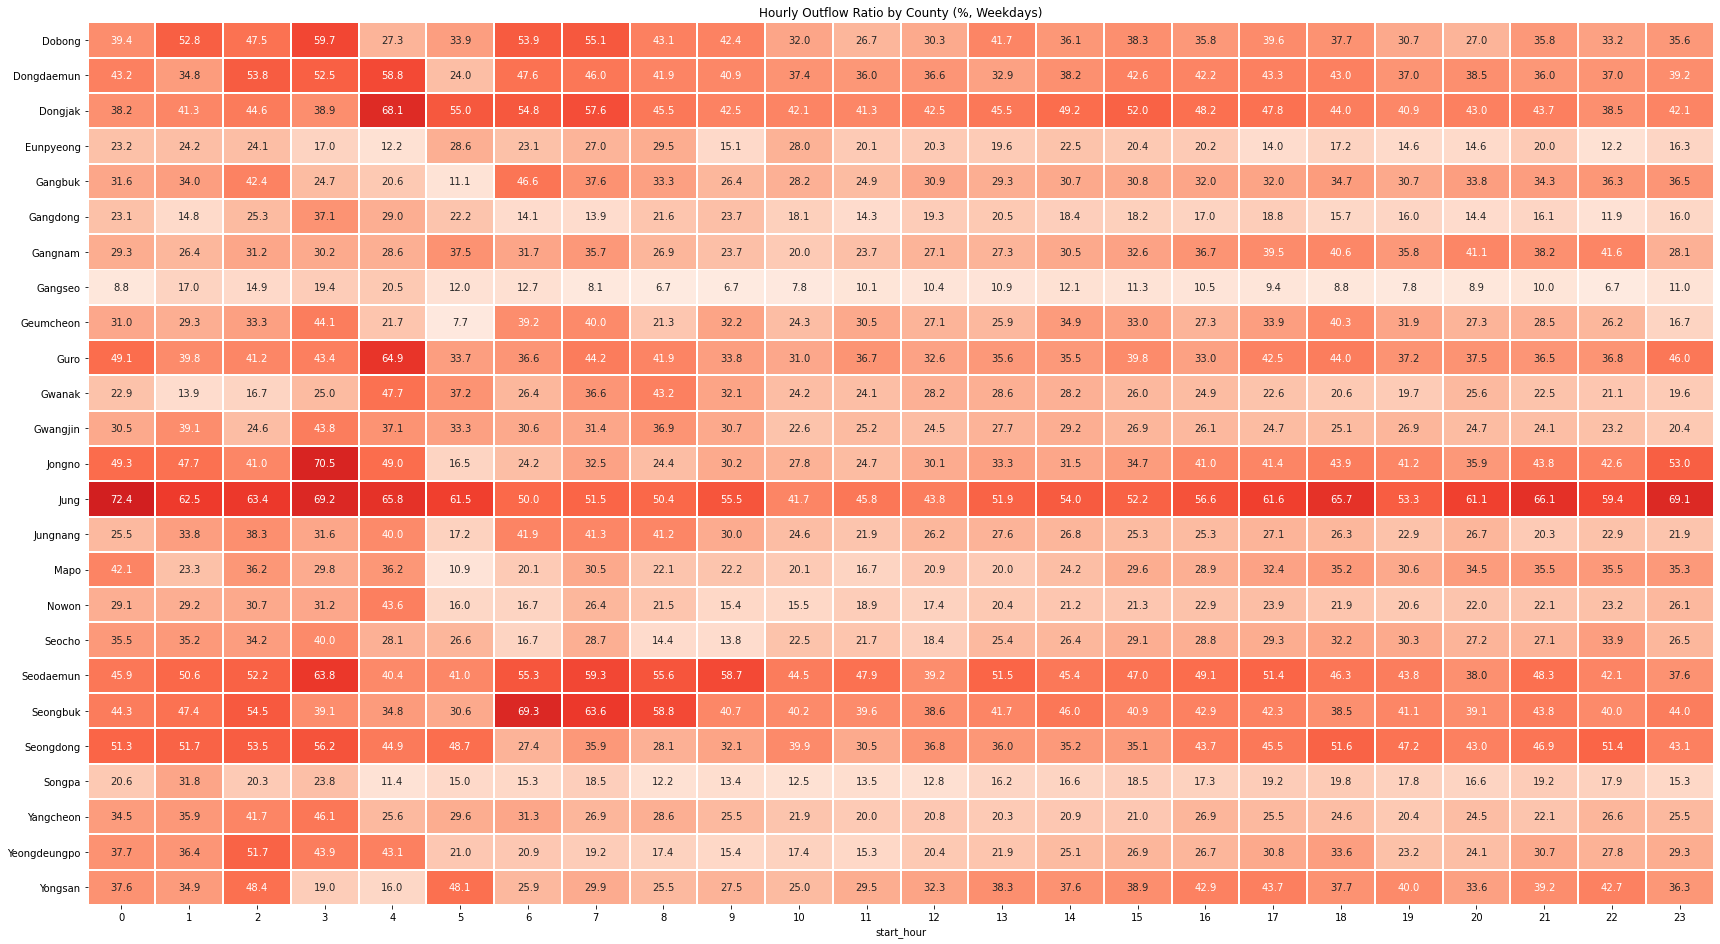

In [123]:
plt.figure(figsize=(24,13))
sns.heatmap(outflow_by_region_weekday.T, square=False, annot=True, fmt=".1f", cmap='Reds', cbar=False, vmin=0, vmax=100, linewidth=1)
plt.tight_layout()
plt.title("Hourly Outflow Ratio by County (%, Weekdays)")
plt.show()

In [133]:
group_by_region_weekday = df[df['start_dayofweek'].isin(set(range(1, 5)))].groupby('county_eng_y')

inflow_by_region_weekday = {}
for name, g_df in group_by_region_weekday:    
    total = g_df.groupby('end_hour').size() 
    g_df = g_df[g_df['county_eng_x'] != name]
    inflow = g_df.groupby('end_hour').size() / total * 100
    inflow_by_region_weekday[name] = inflow

inflow_by_region_weekday = pd.DataFrame(data = inflow_by_region_weekday)

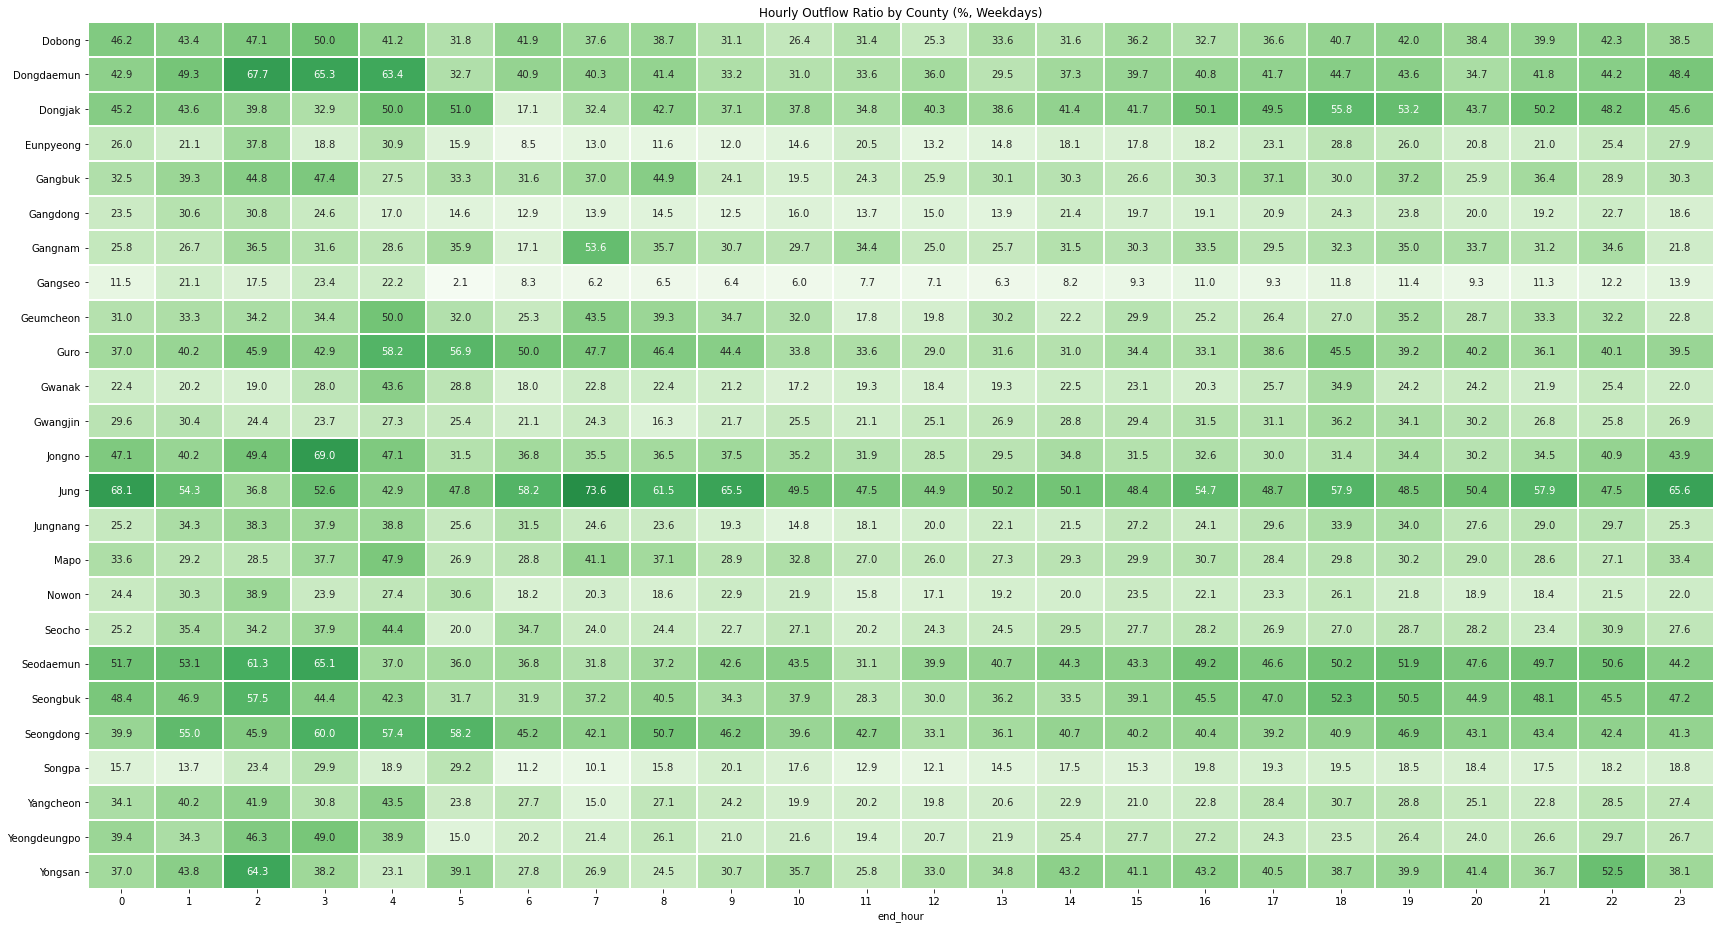

In [134]:
plt.figure(figsize=(24,13))
sns.heatmap(inflow_by_region_weekday.T, square=False, annot=True, fmt=".1f", cmap='Greens', cbar=False, vmin=0, vmax=100, linewidth=1)
plt.title("Hourly Outflow Ratio by County (%, Weekdays)")
plt.tight_layout()
plt.show()

The outflow/inflow ratio have a little bit different patterns!
This finding triggers a question:

- **Are there counties that have simliar outflow/inflow ratio depending on time?**

Since we have to look at outflow/inflow ratio at the same time period, let's take **Measure = Inflow Ratio - Outflow Ratio**
If Measure > 0, more riders are coming to the county in that time period.
If Measure < 0, more riders are going out of the county in that time period.

Let's cluster counties with similar patterns in Measure by time period.

In [135]:
inout_ratio = inflow_by_region_weekday- outflow_by_region_weekday

<Figure size 1728x1728 with 0 Axes>

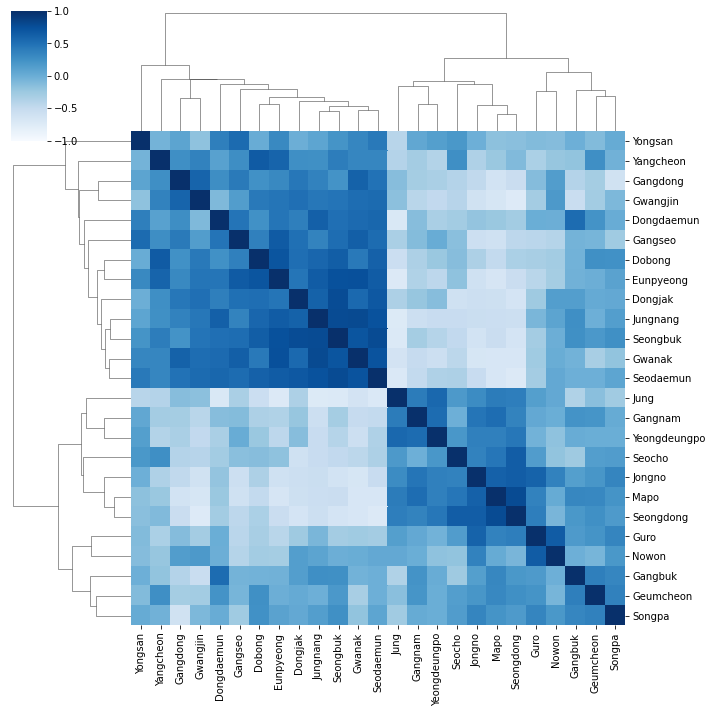

In [136]:
plt.figure(figsize=(24, 24))
clustergrid = sns.clustermap(inout_ratio.corr(), cbar=True, vmin=-1, vmax=1, cmap='Blues')
plt.show()

Do you see the 3 clusters!?
I've named the clusters as A, B, C.

Now, let's plot the Measure by time.

In [137]:
reordered_ind = clustergrid.dendrogram_row.reordered_ind

In [138]:
inout_ratio = inout_ratio.T.reset_index().reindex(reordered_ind).set_index('index')
inout_ratio.index.name = 'county'

In [139]:
inout_ratio

end_hour             0          1          2          3          4   \
county                                                                
Yongsan       -0.597372   8.914982  15.898618  19.187675   7.076923   
Yangcheon     -0.416384   4.361395   0.132769 -15.283401  17.896866   
Gangdong       0.397255  15.804848   5.506073 -12.581454 -12.051126   
Gwangjin      -0.876549  -8.638065  -0.175694 -20.021186  -9.870130   
Dongdaemun    -0.250516  14.544002  13.846154  12.804142   4.591105   
Gangseo        2.731643   4.107063   2.618585   3.952163   1.686508   
Dobong         6.808592  -9.467357  -0.398804  -9.677419  13.903743   
Eunpyeong      2.845127  -3.018217  13.677195   1.778075  18.687231   
Dongjak        7.029801   2.324619  -4.805586  -6.031746 -18.085106   
Jungnang      -0.329803   0.493620   0.019885   6.352087  -1.224490   
Seongbuk       4.098108  -0.560897   2.934860   5.314010   7.459207   
Gwanak        -0.500850   6.303419   2.311436   2.956989  -4.055944   
Seodaemun      5.822499   2.535547   9.051517   1.286262  -3.347578   
Jung          -4.363873  -8.214286 -26.628151 -16.599190 -22.932331   
Gangnam       -3.516857   0.310078   5.271739   1.346389   0.000000   
Yeongdeungpo   1.721378  -2.137956  -5.343137   5.160911  -4.230377   
Seocho       -10.326638   0.187169  -0.069360  -2.068966  16.319444   
Jongno        -2.132505  -7.476636   8.399646  -1.406926  -1.960784   
Mapo          -8.501848   5.874587  -7.759662   7.948615  11.709770   
Seongdong    -11.400694   3.373957  -7.616812   3.835616  12.519272   
Guro         -12.142577   0.361562   4.705882  -0.539084  -6.730463   
Nowon         -4.666363   1.058303   8.213494  -7.346789 -16.208791   
Gangbuk        0.936508   5.323450   2.370600  22.765146   6.911765   
Geumcheon     -0.082102   4.065041   0.877193  -9.742647  28.260870   
Songpa        -4.956660 -18.019097   3.161470   6.111736   7.583732   

end_hour             5          6          7          8          9   ...  \
county                                                               ...   
Yongsan       -9.017713   1.915709  -3.043568  -1.004252   3.136908  ...   
Yangcheon     -5.879630  -3.597776 -11.869235  -1.540075  -1.344923  ...   
Gangdong      -7.615481  -1.191072  -0.039303  -7.087629 -11.182470  ...   
Gwangjin      -7.894737  -9.585666  -7.159064 -20.622872  -9.013087  ...   
Dongdaemun     8.673267  -6.683375  -5.657233  -0.520051  -7.663291  ...   
Gangseo       -9.900138  -4.371073  -1.829930  -0.248987  -0.337645  ...   
Dobong        -2.052786 -11.997100 -17.428883  -4.327443 -11.334931  ...   
Eunpyeong    -12.698413 -14.626219 -14.046157 -17.946708  -3.129151  ...   
Dongjak       -4.019608 -37.721350 -25.205634  -2.768439  -5.395928  ...   
Jungnang       8.314176 -10.399791 -16.659811 -17.626525 -10.652583  ...   
Seongbuk       1.111111 -37.405611 -26.368972 -18.275662  -6.406051  ...   
Gwanak        -8.421424  -8.446344 -13.861386 -20.857385 -10.883399  ...   
Seodaemun     -4.963855 -18.437398 -27.418463 -18.333333 -16.146427  ...   
Jung         -13.712375   8.163265  22.044171  11.071097  10.035473  ...   
Gangnam       -1.602564 -14.561404  17.919255   8.766917   7.071114  ...   
Yeongdeungpo  -5.952381  -0.703332   2.267947   8.731050   5.573803  ...   
Seocho        -6.595745  18.063872  -4.660436  10.023930   8.870912  ...   
Jongno        15.051153  12.577788   2.987547  12.179567   7.300000  ...   
Mapo          15.942761   8.681653  10.518915  15.019355   6.745534  ...   
Seongdong      9.479055  17.784195   6.164420  22.533866  14.086676  ...   
Guro          23.161612  13.448276   3.533678   4.502577  10.638749  ...   
Nowon         14.598109   1.480398  -6.056139  -2.920717   7.442484  ...   
Gangbuk       22.222222 -14.945339  -0.580778  11.529680  -2.298851  ...   
Geumcheon     24.307692 -13.914481   3.529412  17.980753   2.570817  ...   
Songpa        14.213483  -4.074645  -8.411147   3.612640   6.692261  ...   

end_hour             14      

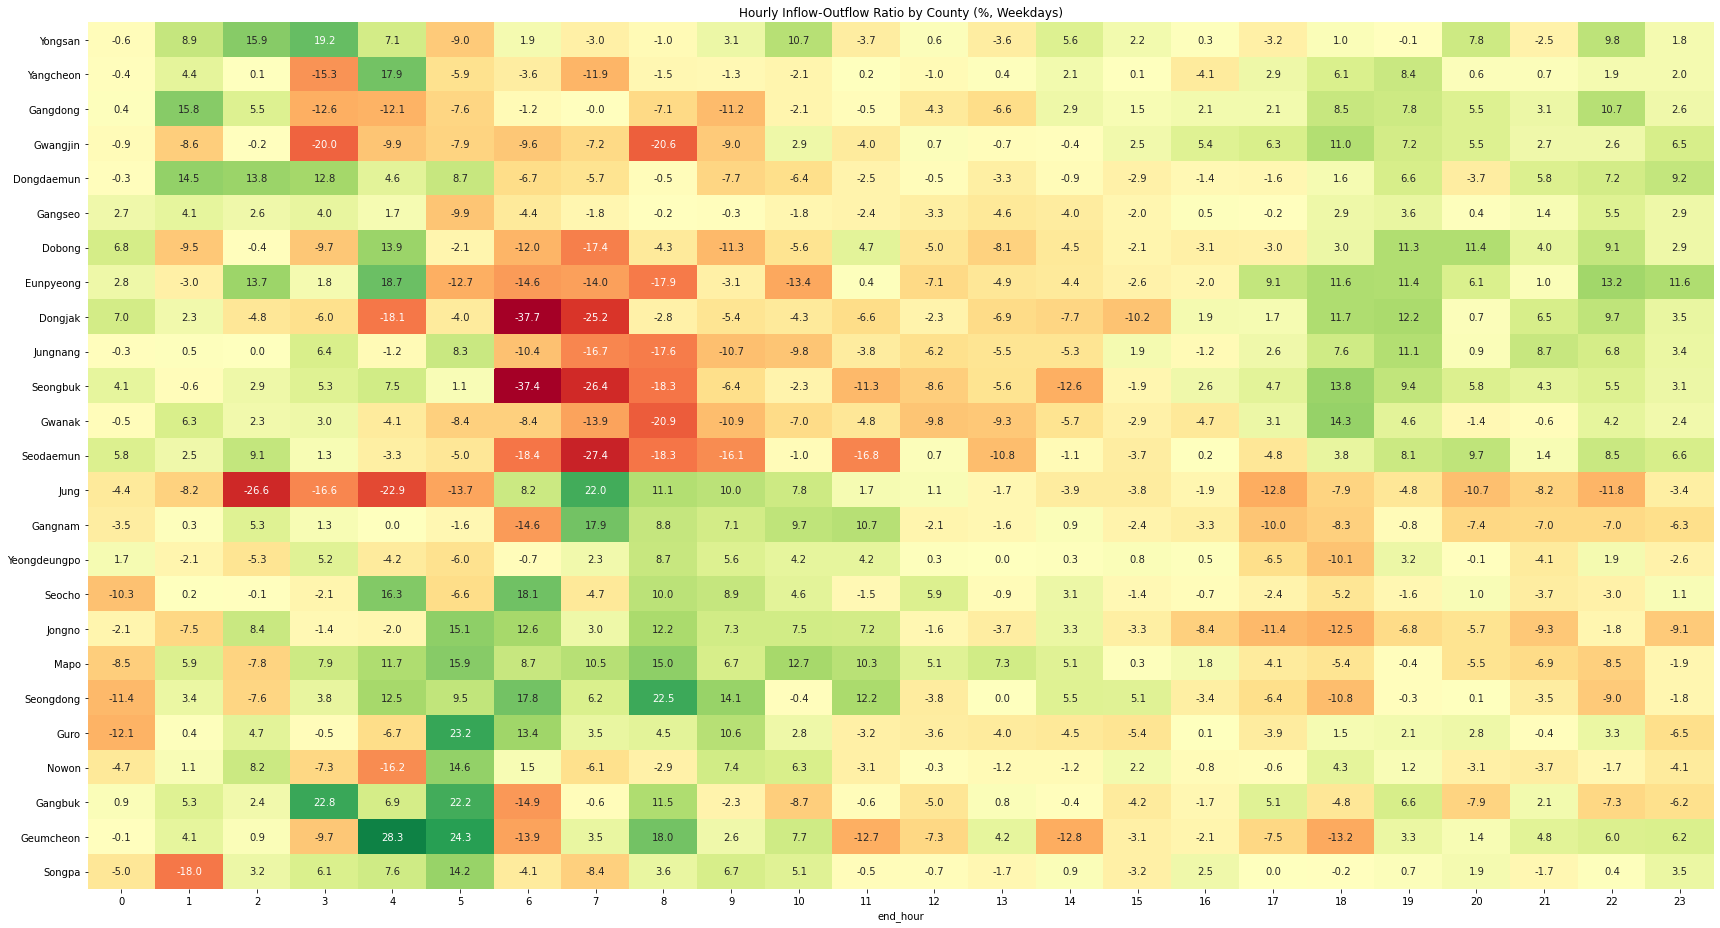

In [140]:
plt.figure(figsize=(24,13))
sns.heatmap(inout_ratio, square=False, annot=True, fmt=".1f", cmap='RdYlGn', cbar=False, vmin=-32, vmax=32)
plt.title("Hourly Inflow-Outflow Ratio by County (%, Weekdays)")
plt.ylabel("")
plt.tight_layout()
plt.show()

**Red = Outflow > Inflow**
**Green = Outflow < Inflow**

The clusters make sense!

**Cluster A** represents counties with high inflow in morning commute time and high outflow in evening commute time. These counties tend to have relatively more companies than other counties.

**Cluster B** is completely opposite of Cluster A. These counties are well known for residence.

**Cluster C** does not belong to either Cluster A or B. Patterns are not as clear as other clusters.

Some abnormalies(?) are that:

- Jung has significantly high outflow ratio from 2 - 4 am
- Gangbuk has very high inflow ratio at 3 am

One thing that crosses my mind is that these abnomalies may be due to distribution of bikes to counties in other stations by trucks.

## In which County do Seoul-ers Commute?

Let's visualize the heatmap 

In [141]:
group_by_region_weekday = df[df['start_dayofweek'].isin(set(range(1, 5)))].groupby('county_x')

outflow_by_region_weekday = {}
for name, g_df in group_by_region_weekday:    
    total = g_df.groupby('start_hour').size() 
    g_df = g_df[g_df['county_y'] != name]
    outflow = g_df.groupby('start_hour').size() / total * 100
    outflow_by_region_weekday[name] = outflow

outflow_by_region_weekday = pd.DataFrame(data = outflow_by_region_weekday)

group_by_region_weekday = df[df['start_dayofweek'].isin(set(range(1, 5)))].groupby('county_y')

inflow_by_region_weekday = {}
for name, g_df in group_by_region_weekday:    
    total = g_df.groupby('end_hour').size() 
    g_df = g_df[g_df['county_x'] != name]
    inflow = g_df.groupby('end_hour').size() / total * 100
    inflow_by_region_weekday[name] = inflow

inflow_by_region_weekday = pd.DataFrame(data = inflow_by_region_weekday)

inout_ratio = inflow_by_region_weekday- outflow_by_region_weekday

reordered_ind = clustergrid.dendrogram_row.reordered_ind

inout_ratio = inout_ratio.T.reset_index().reindex(reordered_ind).set_index('index')
inout_ratio.index.name = 'county'

In [142]:
mean_inout_morning = inout_ratio.iloc[:, 7:10].mean(axis=1)
mean_inout_night = inout_ratio.iloc[:, 17:20].mean(axis=1)

bike_map = bike_map = folium.plugins.DualMap(location=[37.541, 126.986], zoom_start=10, tiles='cartodbpositron', zoom_control=False)
folium.Choropleth(geo_data=geo_str,
                  data=mean_inout_morning,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='RdYlGn',
                  line_color='grey').add_to(bike_map.m1)
folium.Choropleth(geo_data=geo_str,
                  data=mean_inout_night,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='RdYlGn',
                  line_color='grey').add_to(bike_map.m2)
bike_map